In [2]:
import pandas as pd
import numpy as np
from utils import preprocess
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import matplotlib.dates as mdates

In [3]:
df = pd.read_csv("data/1082-Device-Data-Fix.csv")
df = preprocess.get_clean_df(df)

                    date  irrigation_volume_0  \
4316 2023-04-01 00:00:00                  0.0   
4317 2023-04-01 00:30:00                  0.0   
4318 2023-04-01 01:00:00                  0.0   
4319 2023-04-01 01:30:00                  0.0   
4320 2023-04-01 02:00:00                  0.0   

      irrigation_volume_accumulated_0  soil_moisture_20  soil_moisture_40  \
4316                              0.0             0.297             0.316   
4317                              0.0             0.296             0.315   
4318                              0.0             0.296             0.315   
4319                              0.0             0.295             0.314   
4320                              0.0             0.294             0.313   

      soil_moisture_60  
4316             0.204  
4317             0.204  
4318             0.203  
4319             0.202  
4320             0.202  


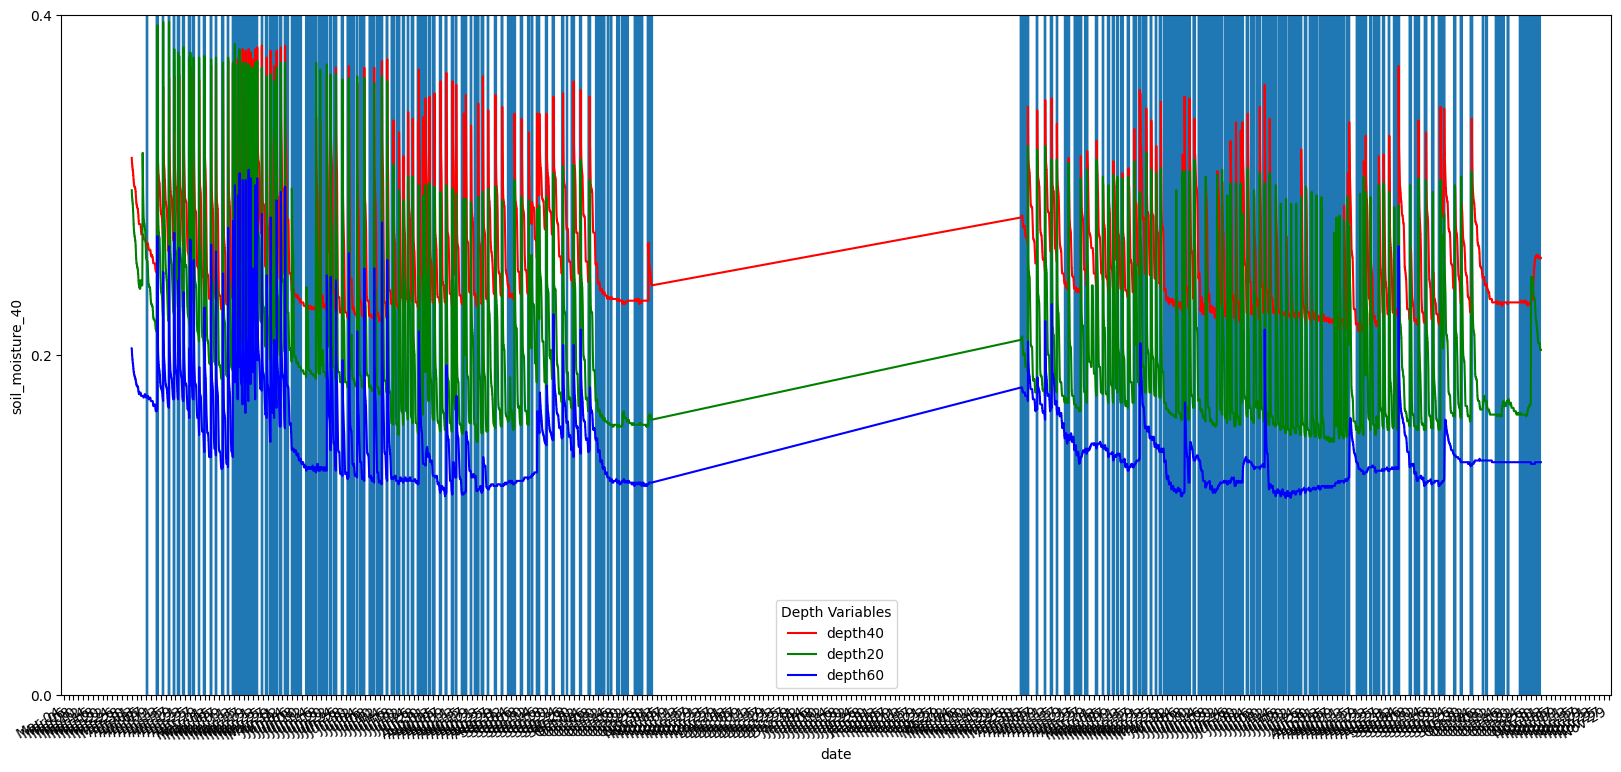

In [ ]:
start_date = pd.to_datetime("2024-04-01")
end_date   = pd.to_datetime("2024-10-10")
df_constricted = df[(df["date"].dt.month >= start_date.month) & (df["date"].dt.month <= end_date.month) & (df["date"].dt.year <= end_date.year)].copy()
# df_constricted = df[(df["date"] >= start_date) & (df["date"] <= end_date) & (df["date"].dt.year <= end_date.year)].copy()
print(df_constricted.head())

#We smooth the values to get a better lecture of peaks
orig_values = df_constricted["soil_moisture_40"].to_numpy()
values = gaussian_filter1d(orig_values, sigma=2)
df_constricted["soil_moisture_40"] = values

df_constricted['prev_value'] = df_constricted['soil_moisture_40'].shift(1)
df_constricted['difference'] = df_constricted['soil_moisture_40'] - df_constricted['prev_value']

df_constricted["peak"] = False
df_constricted["steps_from_peak"] = 0

GRAD_THRESH_HIGH = 0.001

current_steps = -1
up = False

#Mark the peaks and propagates steps from it to the next points
for row in df_constricted.iloc[1:].itertuples(index=True):
    dx = abs(row.difference)
    down = row.difference <= 0
    current_steps += 1
    
    if not down:
        df_constricted.loc[row.Index, "peak"] = True
        current_steps = -1
    else:
        df_constricted.loc[row.Index, "steps_from_peak"] = current_steps


df_constricted["soil_moisture_40"] = orig_values

plt.figure(figsize=(20, 10))

for row in df_constricted.itertuples(index=True):
    if row.peak:
        plt.axvline(df_constricted.loc[row.Index, "date"])
sns.lineplot(df_constricted, x="date", y="soil_moisture_40", label="depth40", color="red")
sns.lineplot(df_constricted, x="date", y="soil_moisture_20", label="depth20", color="green")
sns.lineplot(df_constricted, x="date", y="soil_moisture_60", label="depth60", color="blue")
plt.legend(title="Depth Variables")
plt.ylim(0, 0.40)
plt.yticks([0, 0.20, 0.40])
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gcf().autofmt_xdate()  # rotate labels for clarity
plt.show()

In [5]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

In [6]:
df_decay = df_constricted[~df_constricted["peak"]]
df_decay = df_decay.drop(columns=["irrigation_volume_0", "irrigation_volume_accumulated_0", "prev_value", "difference", "peak"])[1:].reset_index(drop=True)
df_decay["hour"] = df_decay["date"].dt.hour
df_decay["season"] = df_decay["date"].dt.month.apply(get_season)
df_decay = pd.get_dummies(df_decay, columns=['season'])
df_decay['soil_moisture_next'] = df_decay['soil_moisture_40'].shift(-1)
df_decay['next_steps'] = df_decay['steps_from_peak'].shift(-1)
df_decay = df_decay[df_decay["next_steps"] != 0]
df_decay = df_decay.drop(columns=["date", "soil_moisture_20", "soil_moisture_60", "next_steps"])[:-1]
df_decay.head()

soil_moisture_40  steps_from_peak  hour  season_autumn  season_spring  \
0             0.315                0     0          False           True   
1             0.315                1     1          False           True   
2             0.314                2     1          False           True   
3             0.313                3     2          False           True   
4             0.313                4     2          False           True   

   season_summer  soil_moisture_next  
0          False               0.315  
1          False               0.314  
2          False               0.313  
3          False               0.313  
4          False               0.313

In [7]:
X_train = df_decay[["soil_moisture_40", "steps_from_peak", "hour", "season_autumn", "season_spring", "season_summer"]].copy()
X_train["hour"] = X_train["hour"] / 24
print(X_train.head())

y_train = df_decay["soil_moisture_next"]
print(y_train)

   soil_moisture_40  steps_from_peak      hour  season_autumn  season_spring  \
0             0.315                0  0.000000          False           True   
1             0.315                1  0.041667          False           True   
2             0.314                2  0.041667          False           True   
3             0.313                3  0.083333          False           True   
4             0.313                4  0.083333          False           True   

   season_summer  
0          False  
1          False  
2          False  
3          False  
4          False  
0        0.315
1        0.314
2        0.313
3        0.313
4        0.313
         ...  
16443    0.257
16444    0.257
16445    0.257
16446    0.257
16447    0.257
Name: soil_moisture_next, Length: 16118, dtype: float64


In [8]:
from utils.models import *
from utils.preprocess import *
import xgboost as xgb
from utils.eval import *

ESTIMATORS = 700
DEPTH = 3
DIFF = True

X_new = X_train.copy()

X_new["Input_0"] = X_new["soil_moisture_40"]
X_new["Output_1"] = X_new["soil_moisture_40"].shift(-1)
X_new["Output_2"] = X_new["soil_moisture_40"].shift(-2)
X_new["Output_3"] = X_new["soil_moisture_40"].shift(-3)
X_new["season_autumn"] = X_new["season_autumn"].astype(bool)
X_new["season_summer"] = X_new["season_summer"].astype(bool)
X_new["season_spring"] = X_new["season_spring"].astype(bool)
X_new["current_step"] = X_new["steps_from_peak"].shift(-3)
X_new["hour"] = X_new["hour"]
X_new["hour_s"] = np.sin(2 * np.pi * X_new["hour"])
X_new["hour_c"] = np.cos(2 * np.pi * X_new["hour"])
condition = X_new["current_step"] >= 3
condition_full = ~X_new["Output_3"].isna() & condition
X_new = X_new.loc[condition_full]

y_new = X_new[["Output_1", "Output_2", "Output_3"]]
X_new = X_new[["Input_0", "current_step", "hour_s", "hour_c", "season_autumn", "season_spring", "season_summer"]]

X_new.head()

Input_0  current_step    hour_s    hour_c  season_autumn  season_spring  \
0    0.315           3.0  0.000000  1.000000          False           True   
1    0.315           4.0  0.258819  0.965926          False           True   
2    0.314           5.0  0.258819  0.965926          False           True   
3    0.313           6.0  0.500000  0.866025          False           True   
4    0.313           7.0  0.500000  0.866025          False           True   

   season_summer  
0          False  
1          False  
2          False  
3          False  
4          False

In [9]:
y_new

Output_1  Output_2  Output_3
0         0.315     0.314     0.313
1         0.314     0.313     0.313
2         0.313     0.313     0.313
3         0.313     0.313     0.313
4         0.313     0.313     0.312
...         ...       ...       ...
16440     0.257     0.257     0.257
16441     0.257     0.257     0.257
16442     0.257     0.257     0.257
16443     0.257     0.257     0.257
16444     0.257     0.257     0.257

[15158 rows x 3 columns]

In [10]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()
xgb_reg.fit(X_new, y_new)
xgb_pred = xgb_reg.predict(X_new)
pd.DataFrame(xgb_pred, columns=['Y1', 'Y2', 'Y3'])
mae = mean_absolute_error(y_new, xgb_pred)
print("MAE:", mae)

MAE: 0.0006092121475376189


In [11]:
def create_frame_pointed(df_predicted,new_prediction,frame,idx):

    plt.figure(figsize=(15, 5))
    sns.scatterplot(x=df_predicted.loc[:idx, "date"], y=df_predicted.loc[:idx, "soil_moisture_40"], color="Blue", label="Seen points")
    plt.xlim(start_date, end_date)
    plt.ylim(0.20, 0.35)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.gcf().autofmt_xdate()  # rotate labels for clarity
    sns.lineplot(new_prediction, x="date", y="soil_moisture_40", color="Red", label="Predicted")
    sns.lineplot(new_prediction, x="date", y="real_values", color="Green", label="Real future behaviour")
    plt.legend(loc="upper right")
    plt.show()
    # plt.savefig(f"frames_ML/frame{frame:04d}.png")
    # plt.close()

In [ ]:
def get_model_input(moisture, df, idx, steps):

    model_input = [[moisture],
                   [steps],
                   df.loc[idx, ["season_autumn", "season_spring", "season_summer"]].values,
                   ]

    model_input = np.concat(model_input)


    model_input = pd.DataFrame(model_input.reshape(1, -1), columns=["Input_0", "current_step", "season_autumn", "season_spring", "season_summer"])
    model_input = model_input.astype(X_new.dtypes[model_input.columns])
    model_input["hour_s"] = np.sin(2 * np.pi * df.loc[idx, "date"].hour)
    model_input["hour_c"] = np.cos(2 * np.pi * df.loc[idx, "date"].hour)
    model_input = model_input[["Input_0", "current_step", "hour_s", "hour_c", "season_autumn", "season_spring", "season_summer"]]
    return model_input

def update_prediction(df_predicted, model, starting_idx):

    MAX_STEPS = 100
    
    dates = [df_predicted.loc[starting_idx, "date"]]
    values = [df_predicted.loc[starting_idx, "soil_moisture_40"]]
    stop_steps = None
    
    #We predict only up to the next irrigation for a better viewing for the animation
    #We predict 3 next values simultaneously and use last one to continue the forecasting
    
    for step in range(0, MAX_STEPS, 3):

        if df_predicted.loc[starting_idx + step, "irrigation_volume_0"] > 0:
            stop_steps = step
            break

        model_input = get_model_input(values[-1], df_predicted, starting_idx, step)

        # dates = np.concat(dates, df_predicted.loc[starting_idx + step:starting_idx + step + 3, "date"])

        new_values = model.predict(model_input)
        
        values = np.concat([values, new_values.flatten()])

    if stop_steps is None:
        stop_steps = MAX_STEPS + 2

    df = pd.DataFrame({
    "date": df_predicted.loc[starting_idx:starting_idx + stop_steps, "date"],
    "soil_moisture_40": values,
    "real_values" : df_predicted.loc[starting_idx:starting_idx + stop_steps, "soil_moisture_40"]
    })

    return df

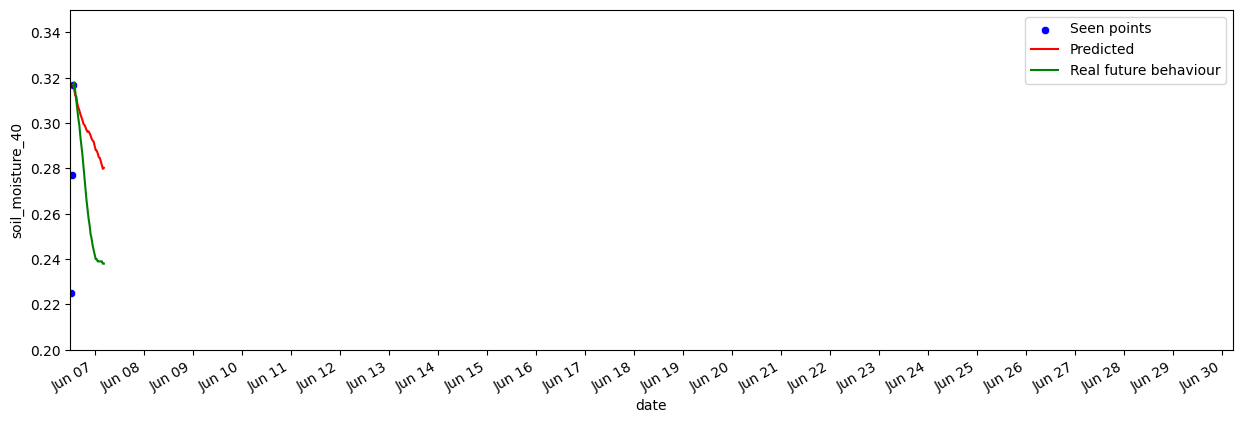

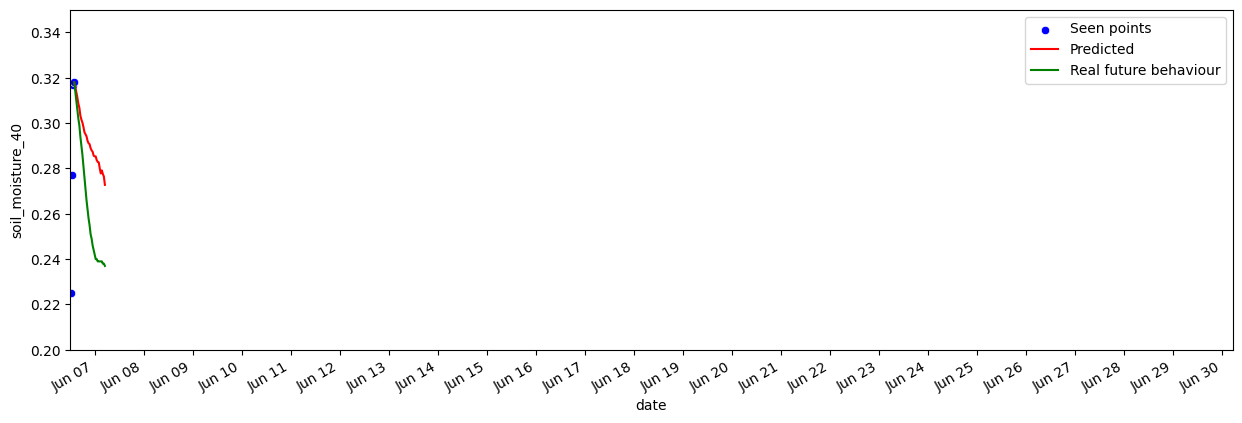

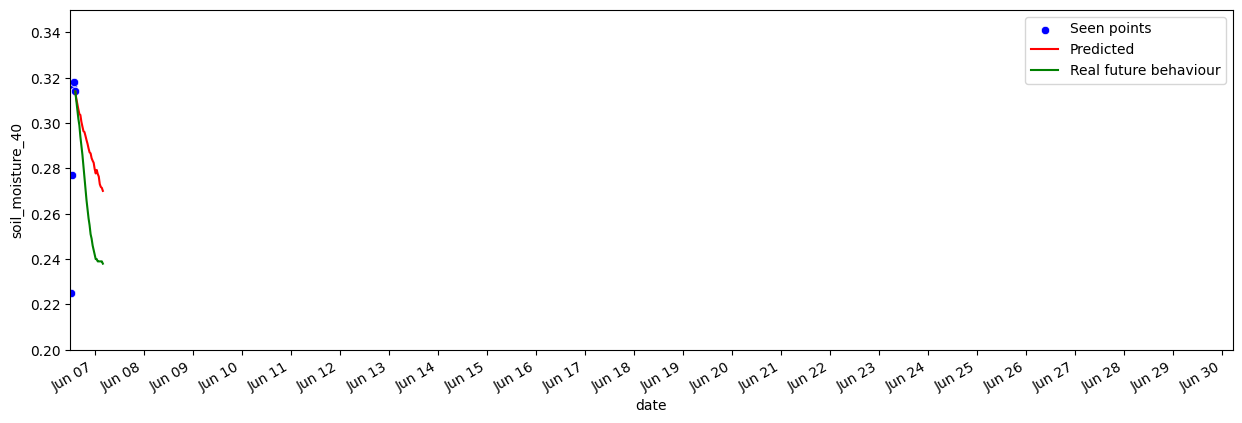

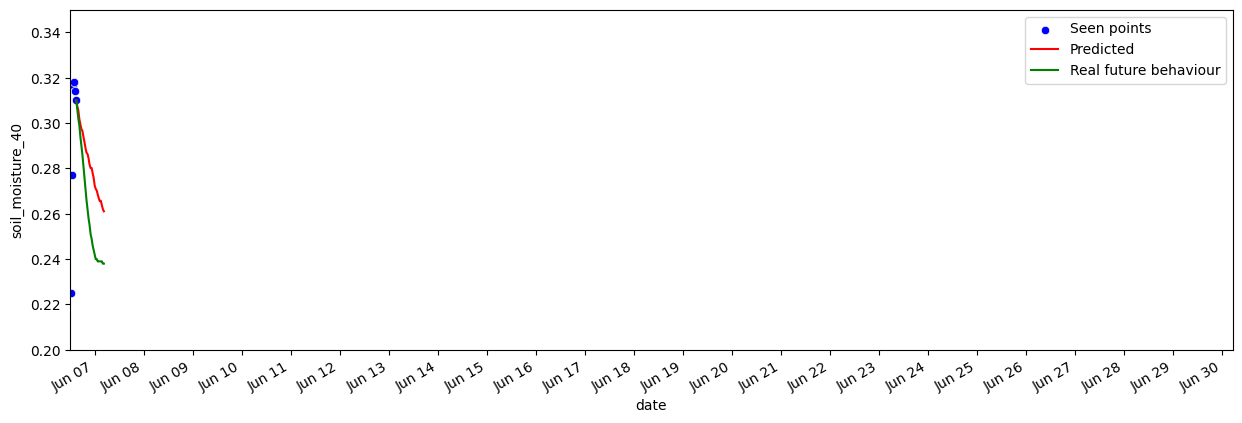

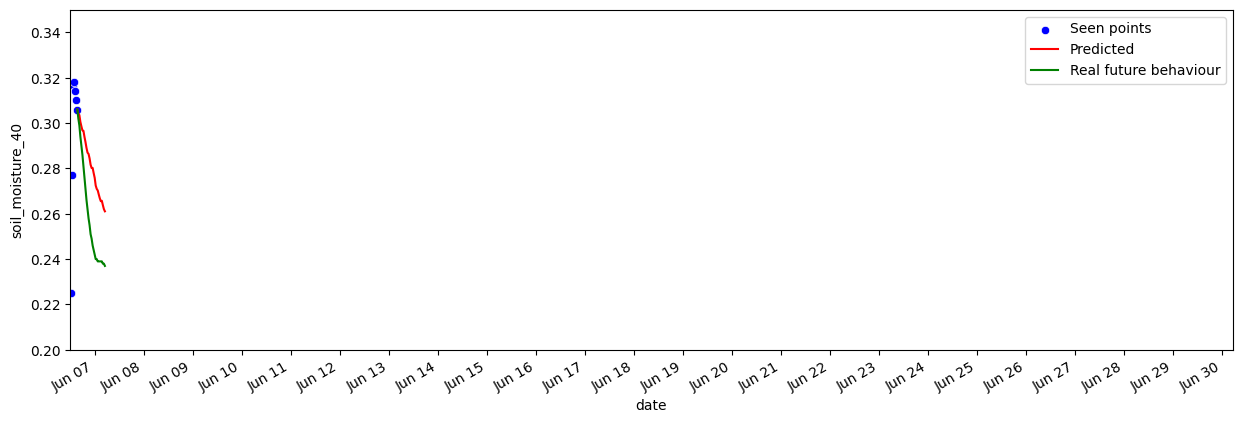

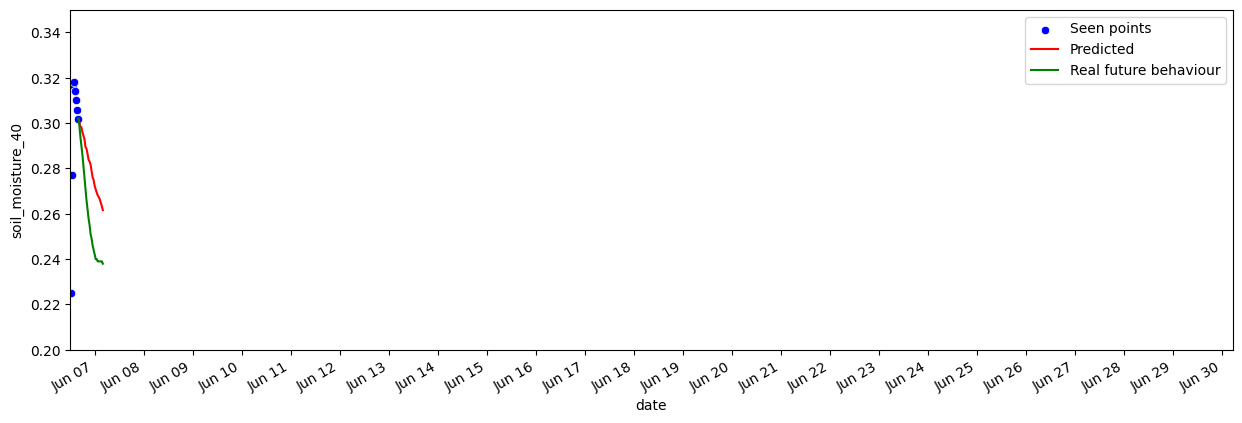

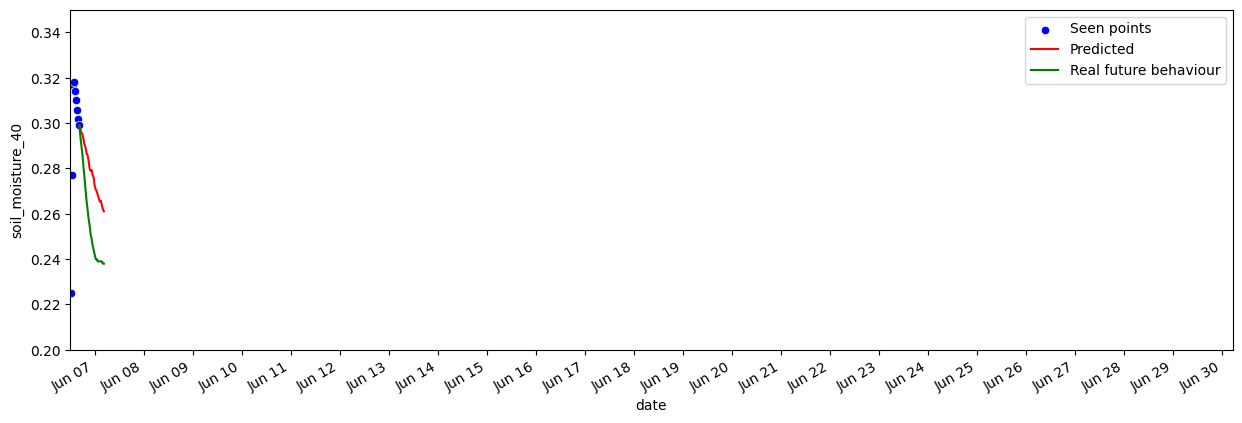

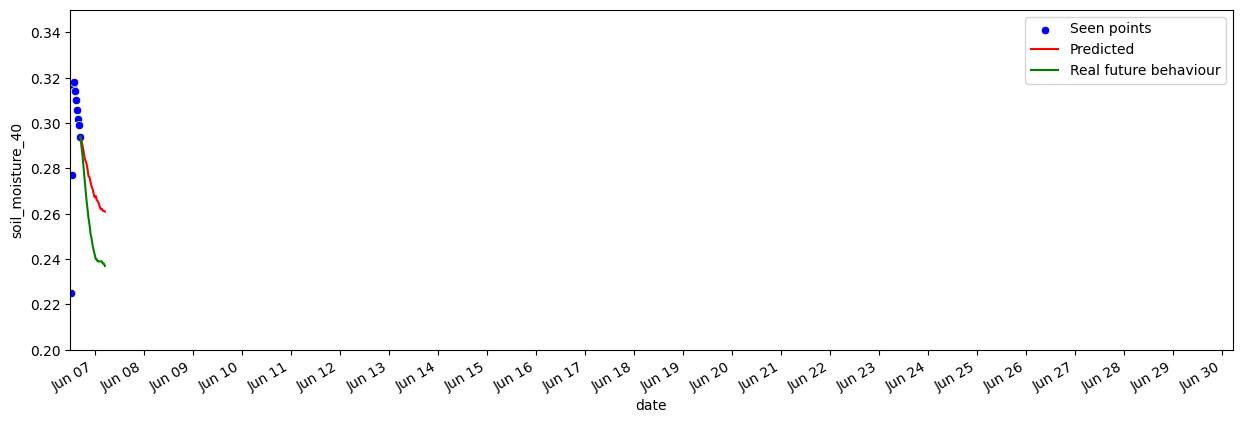

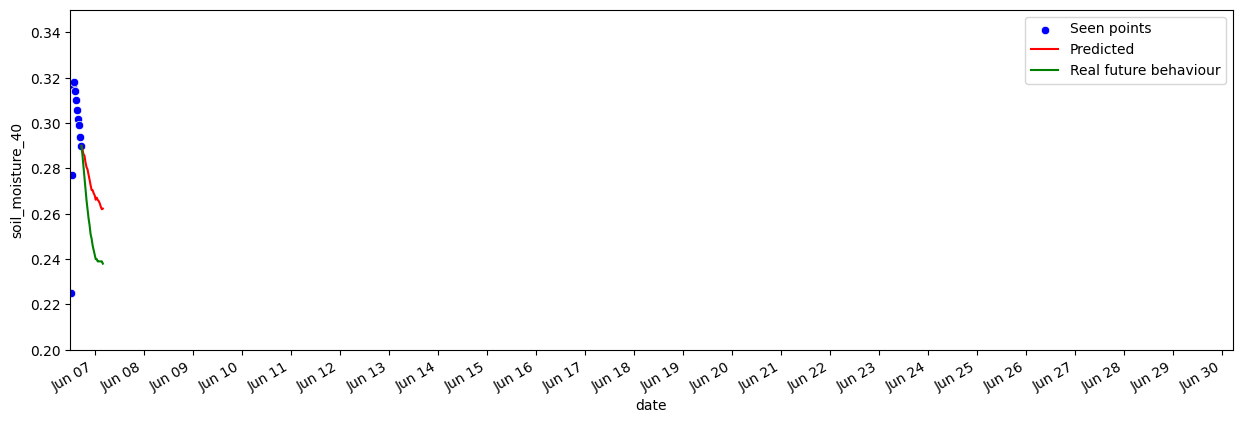

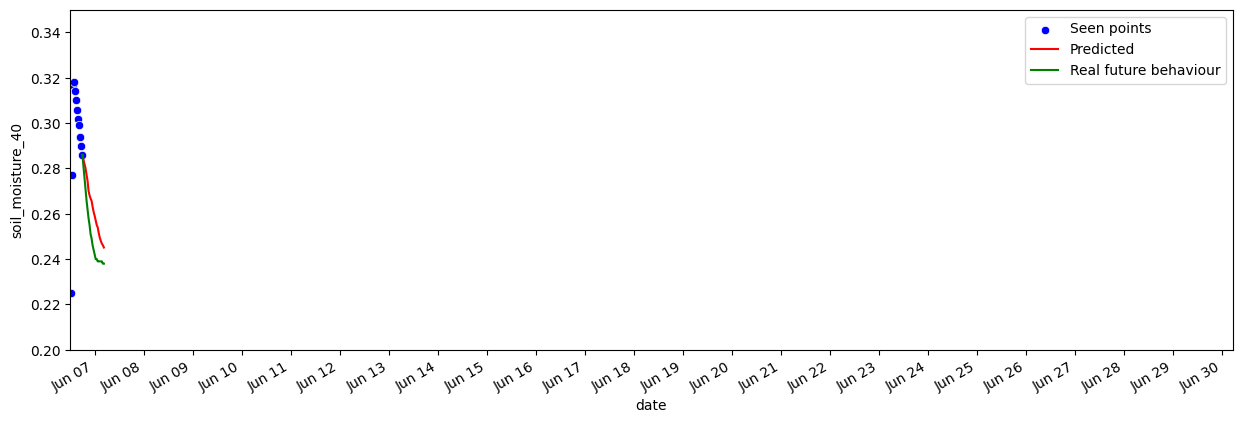

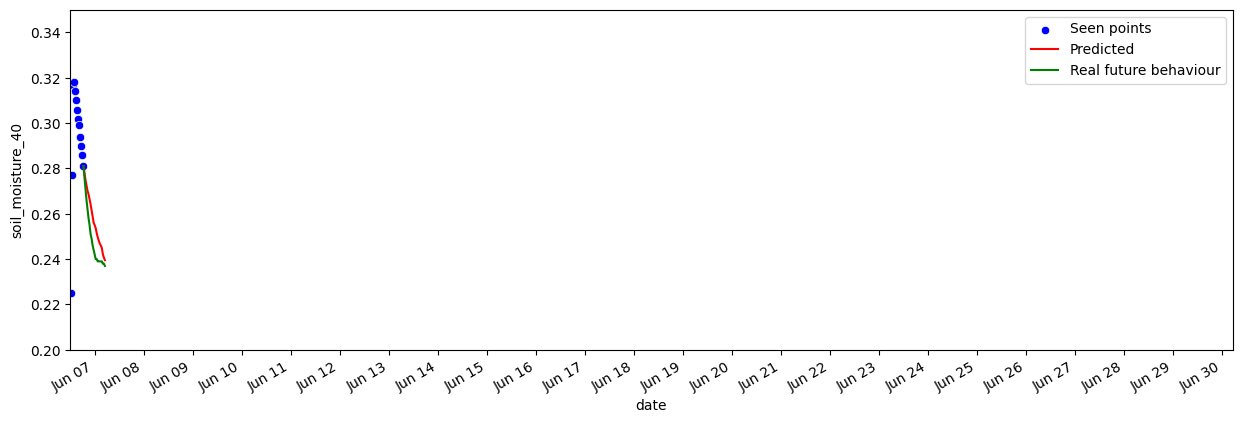

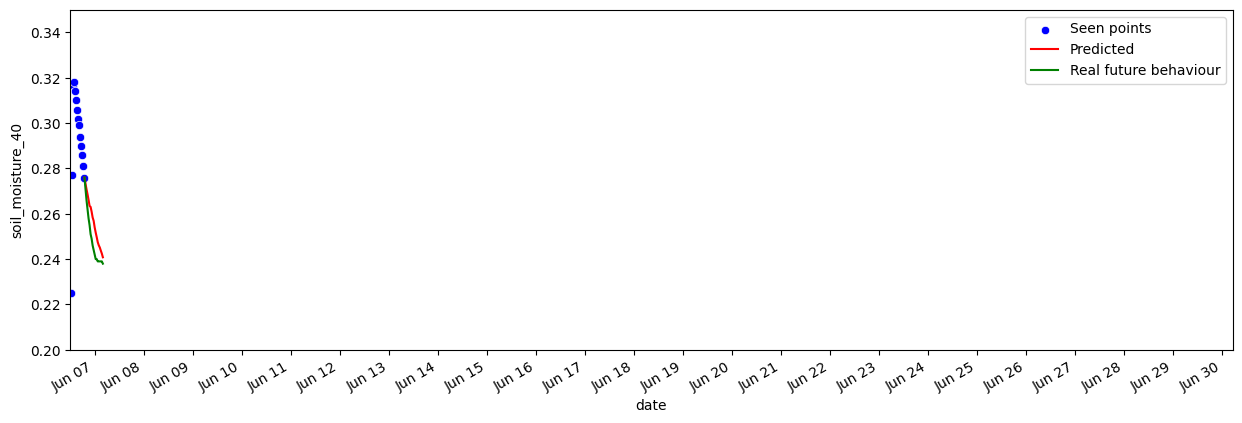

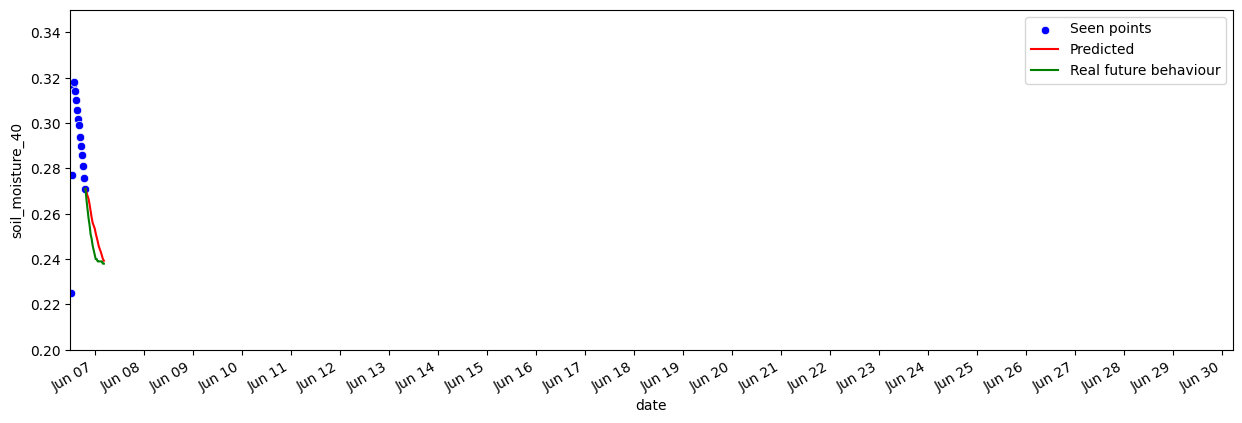

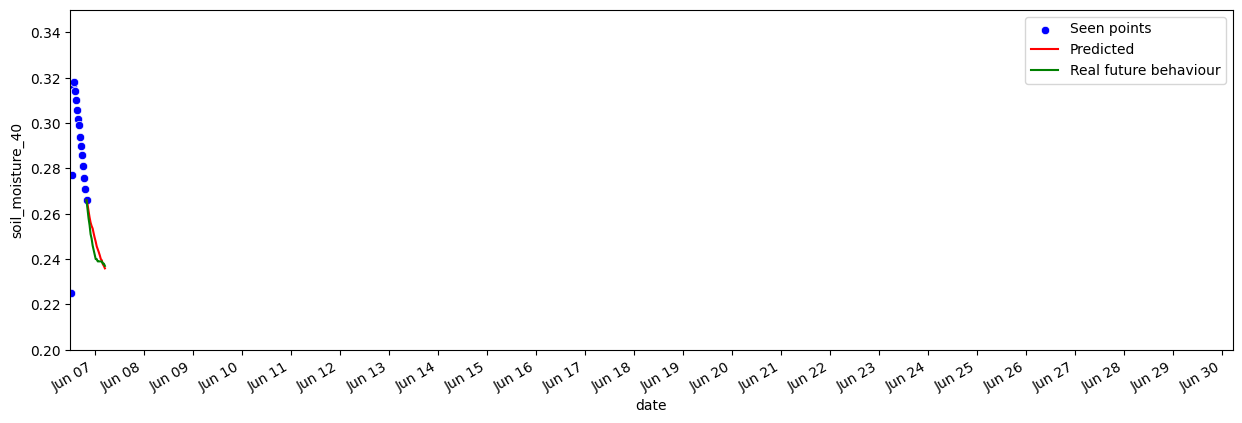

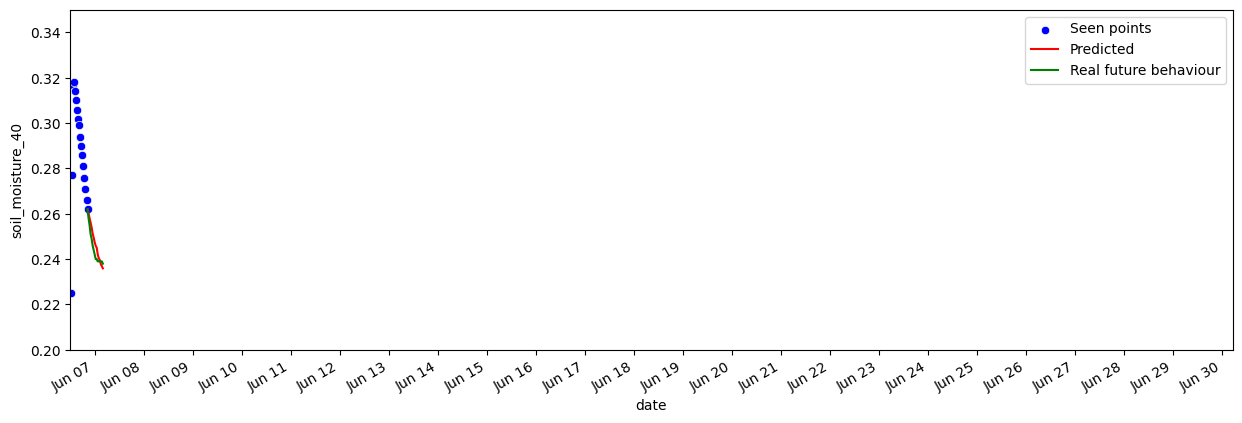

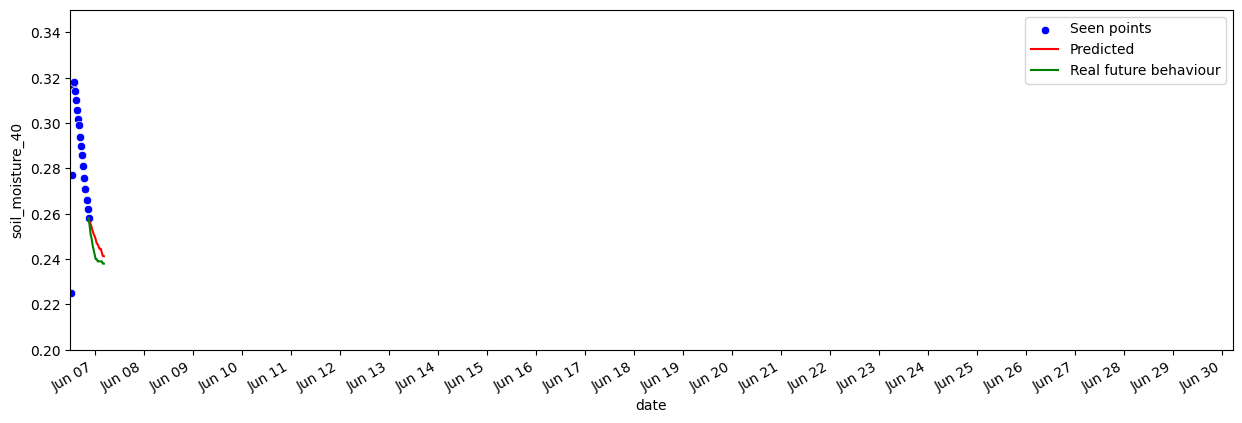

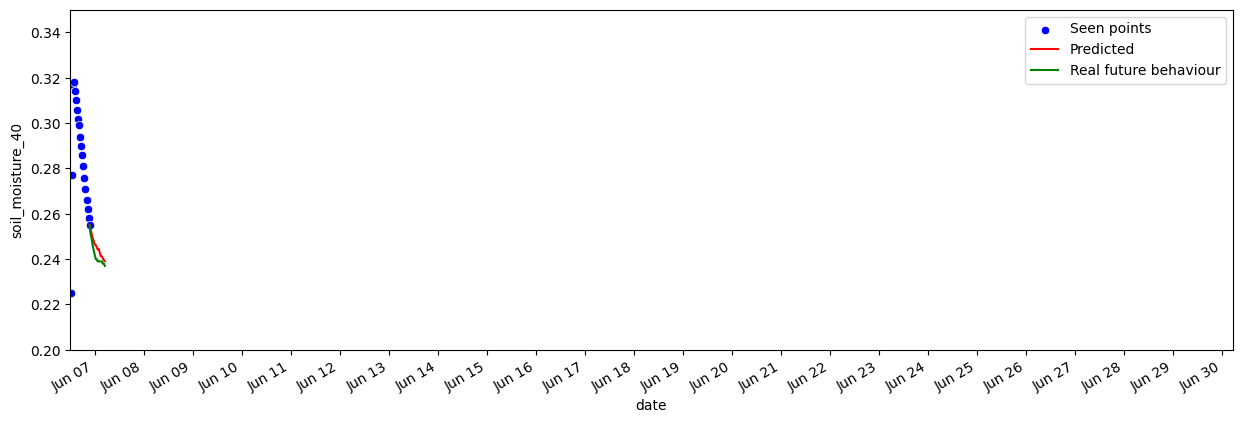

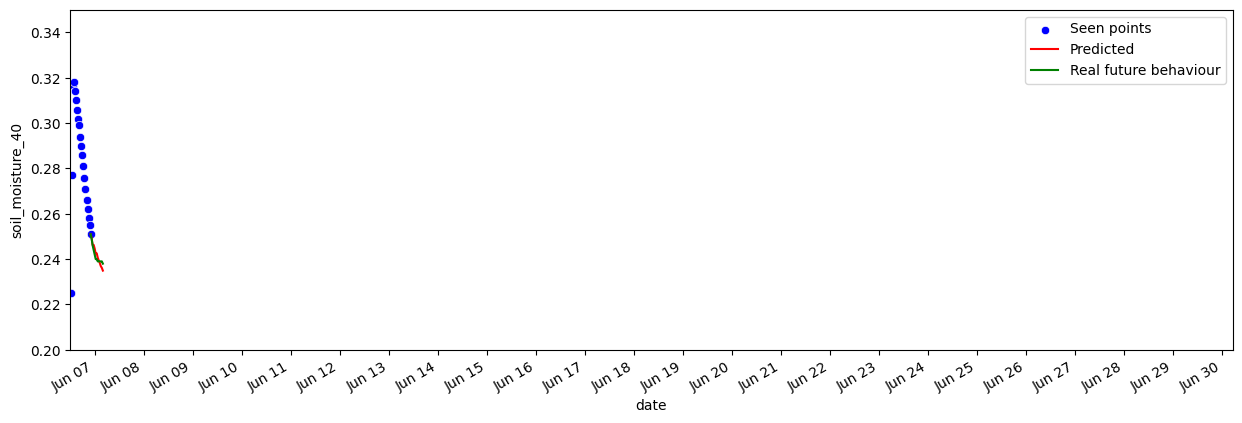

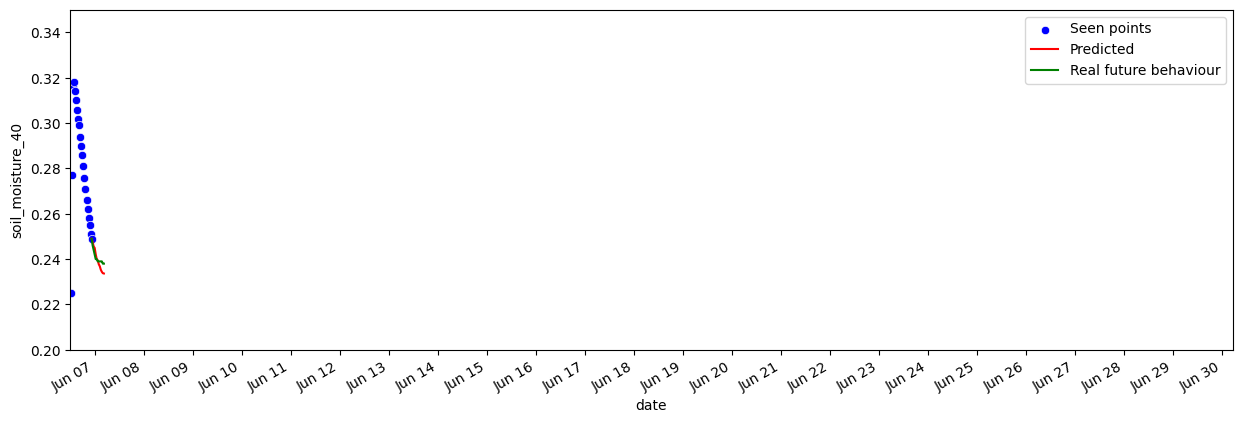

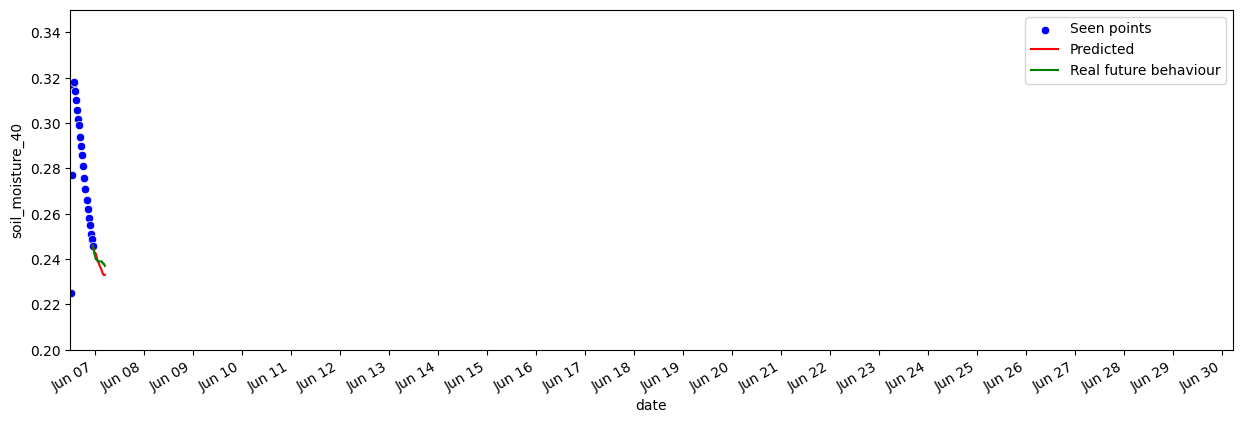

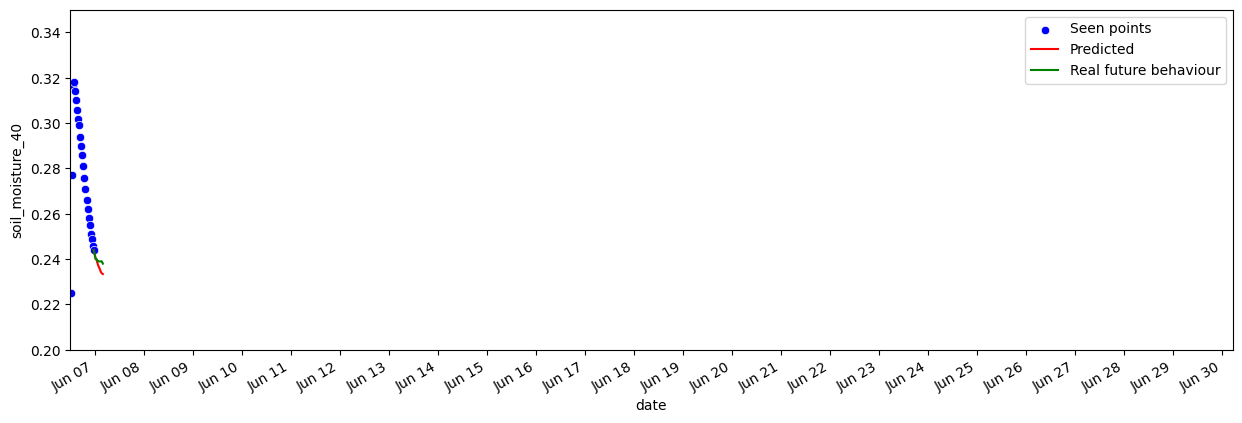

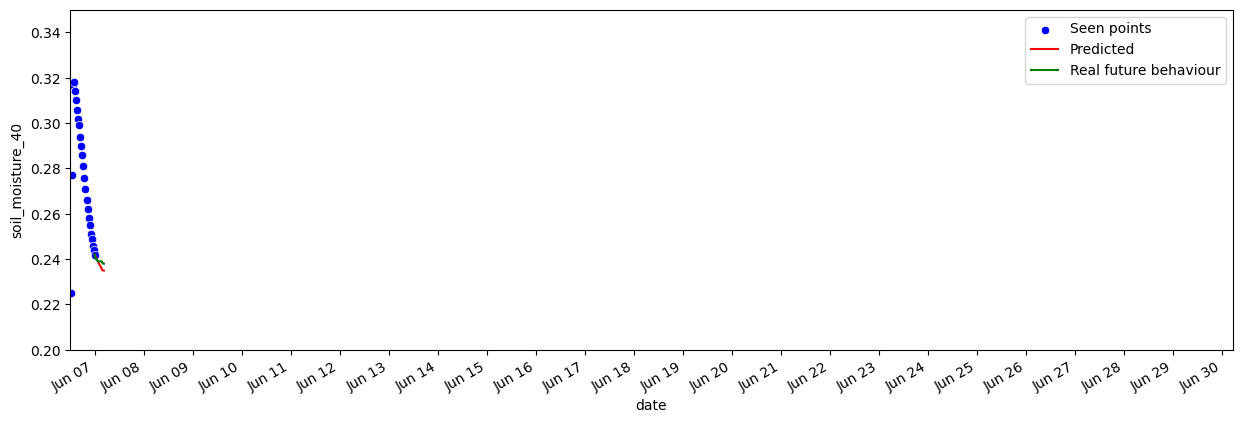

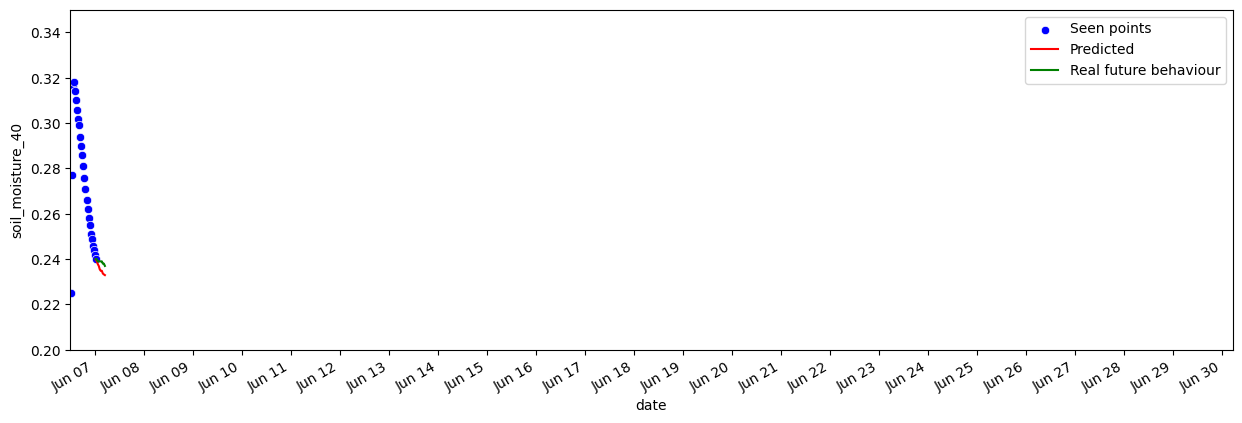

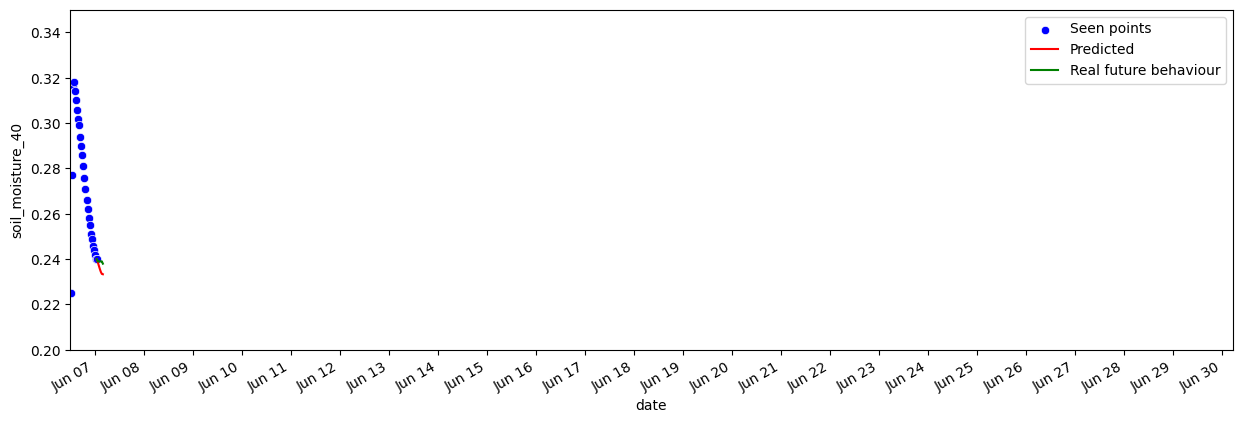

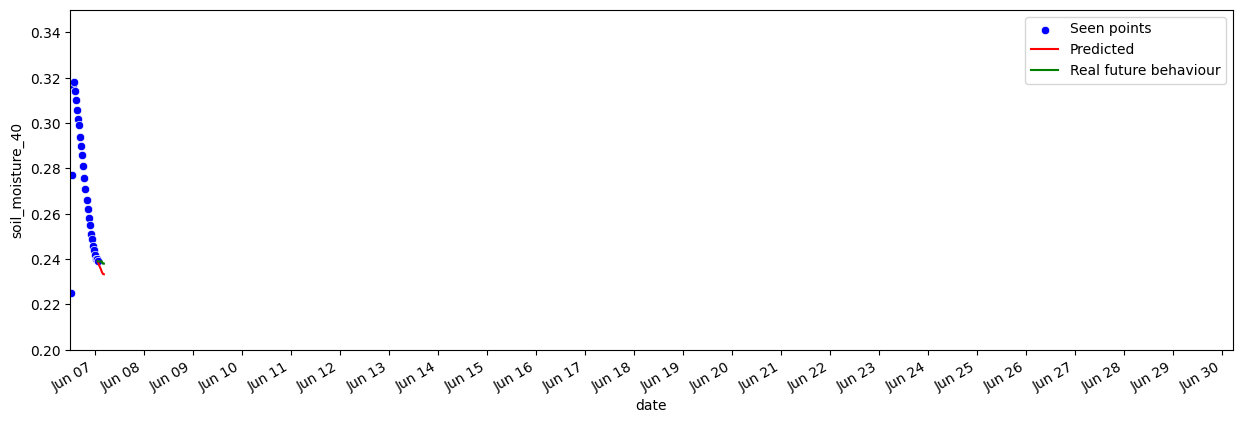

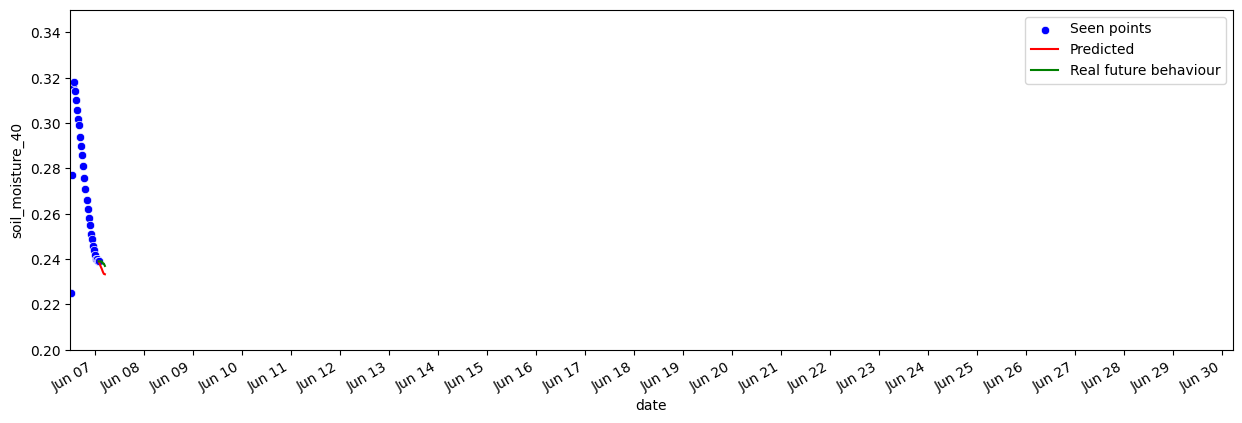

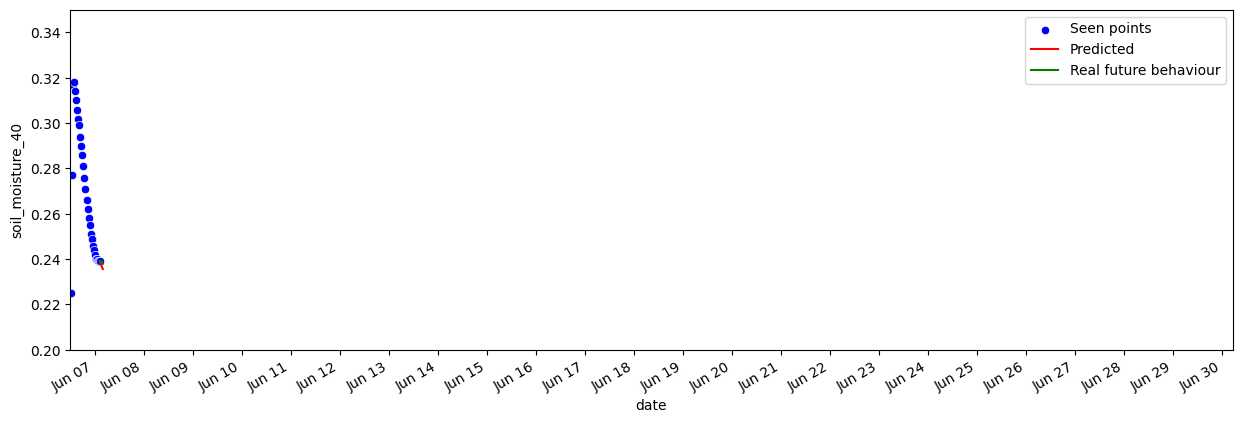

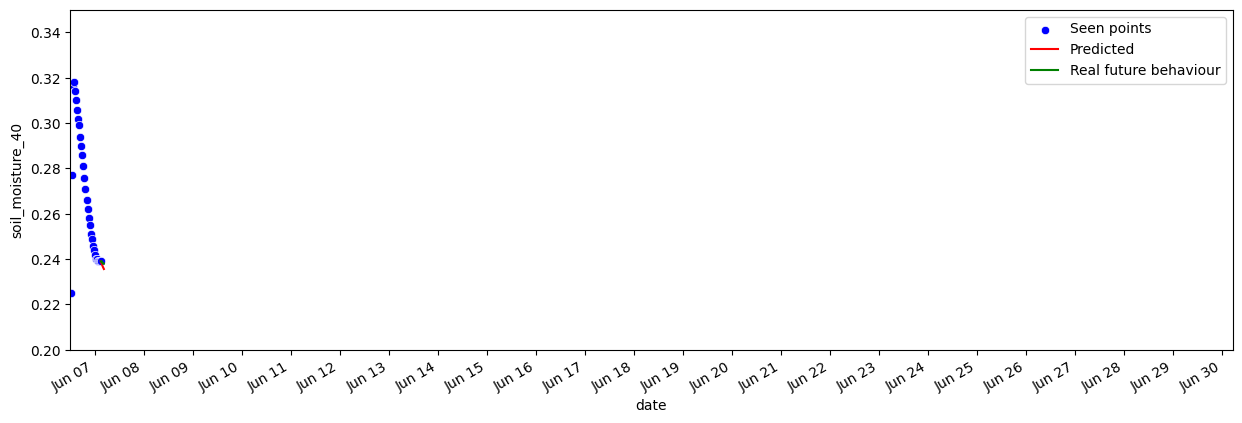

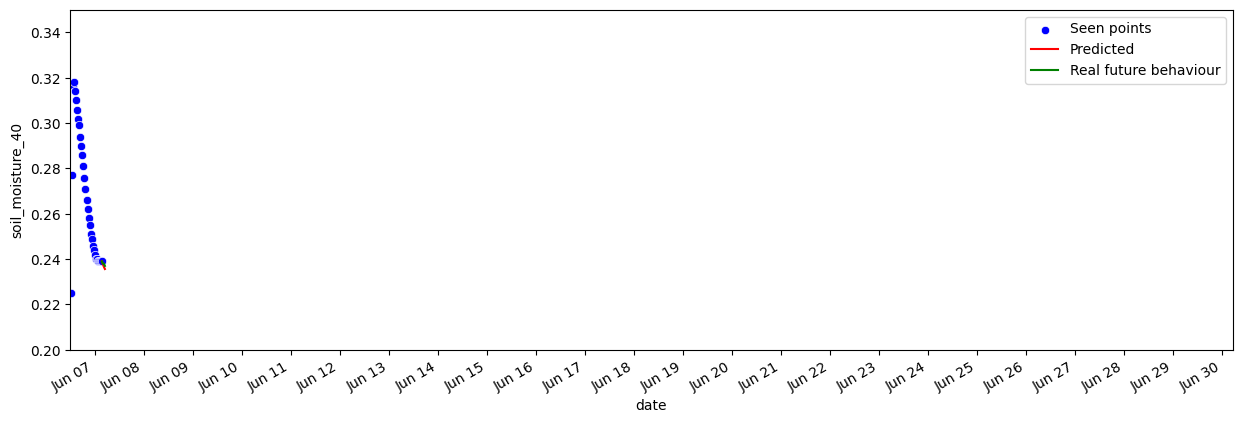

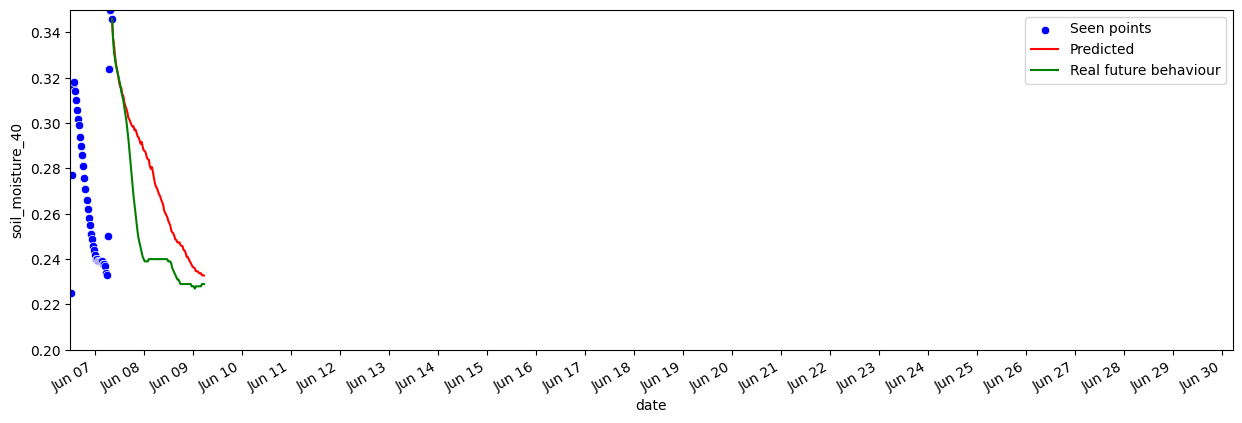

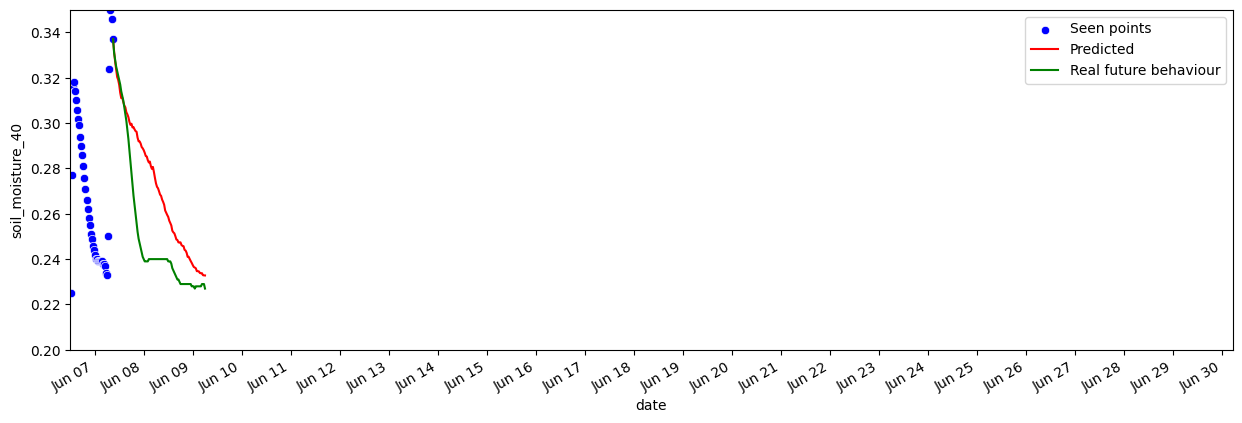

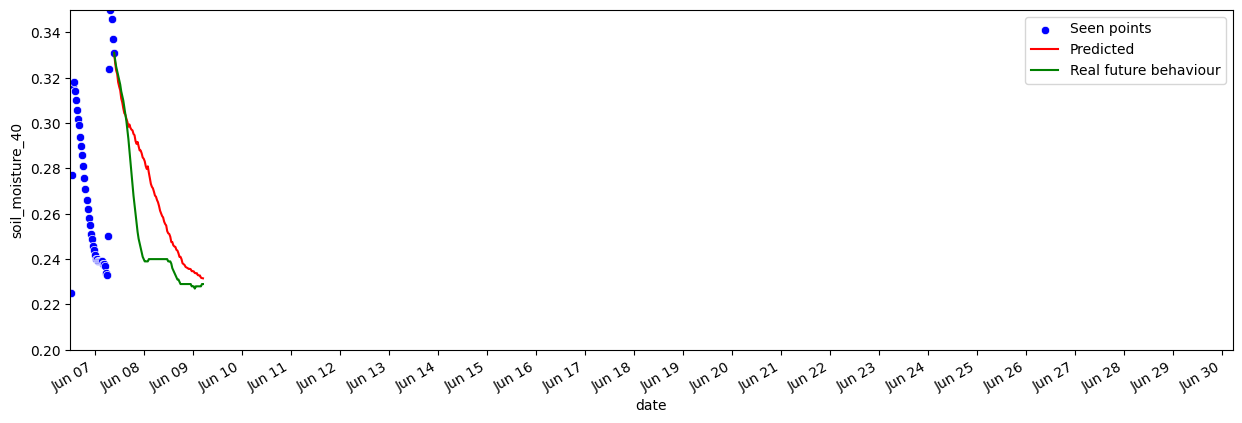

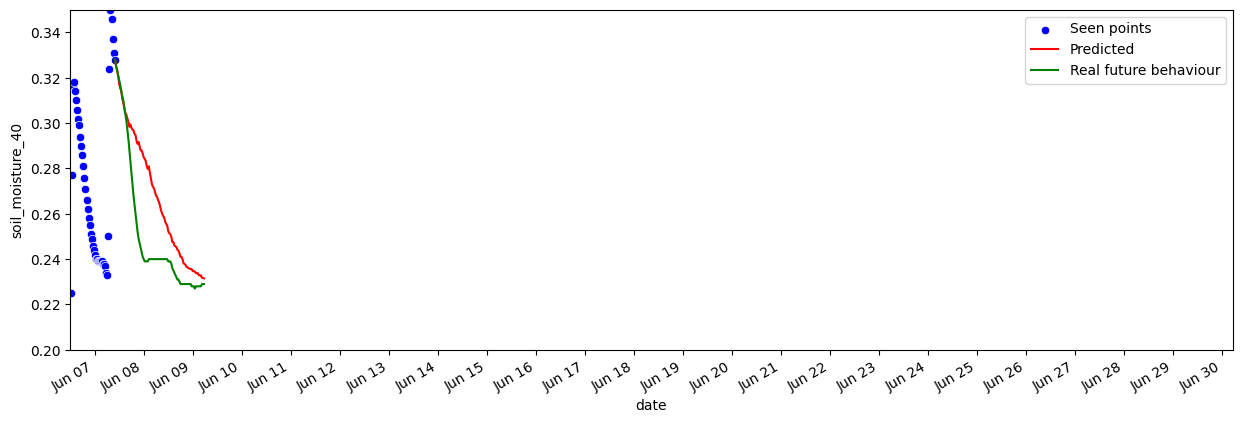

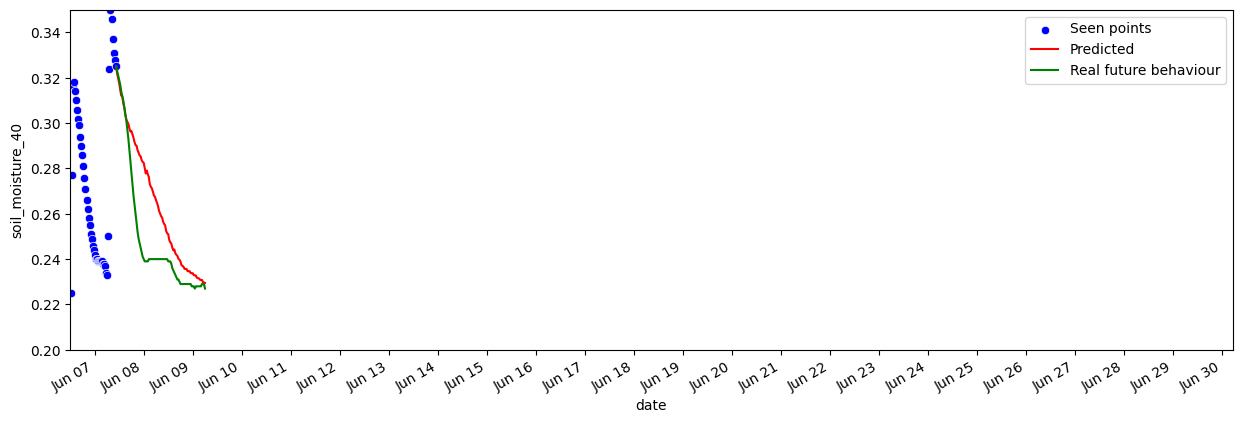

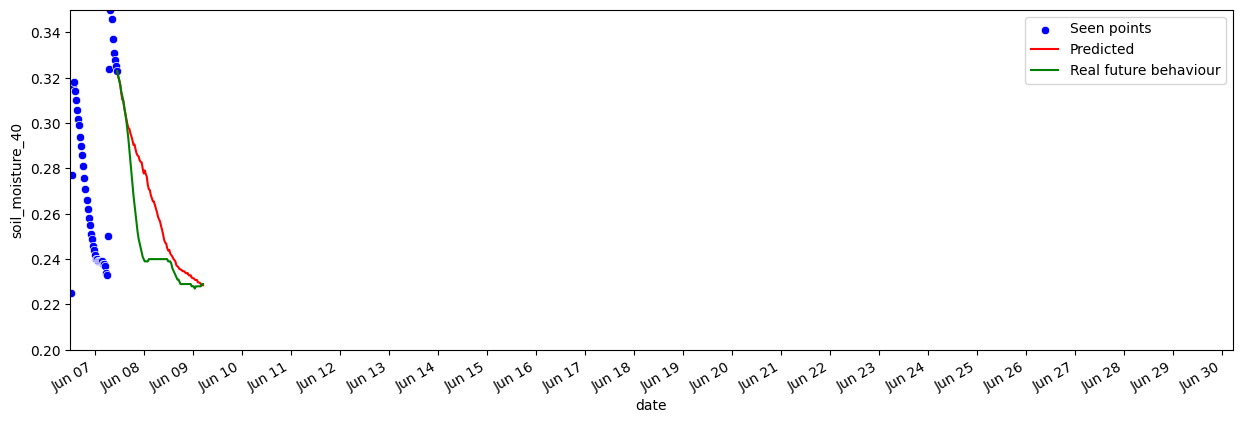

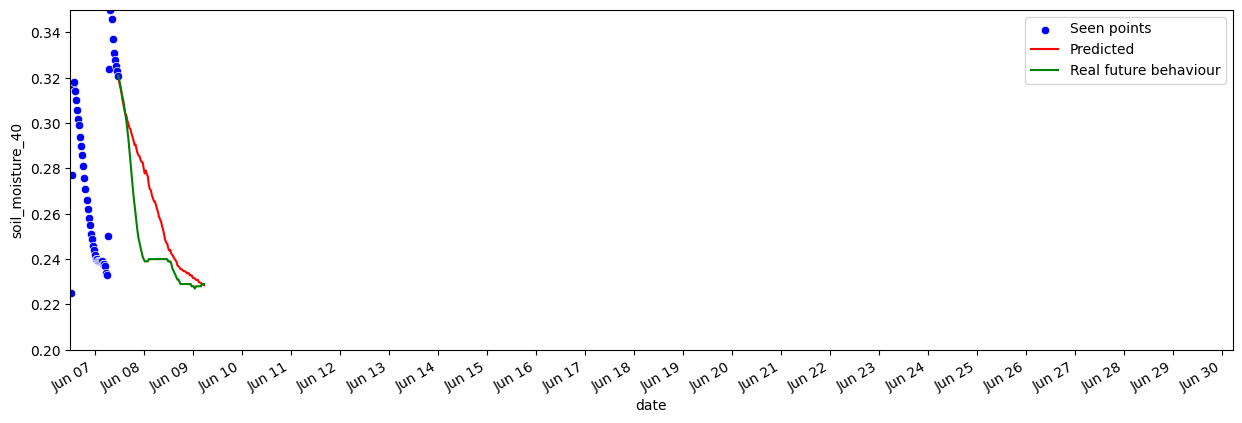

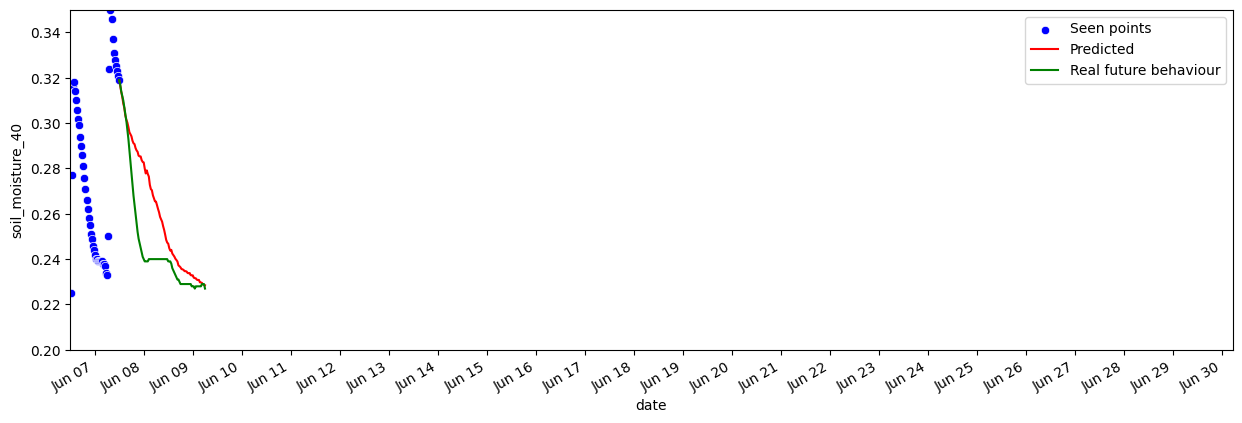

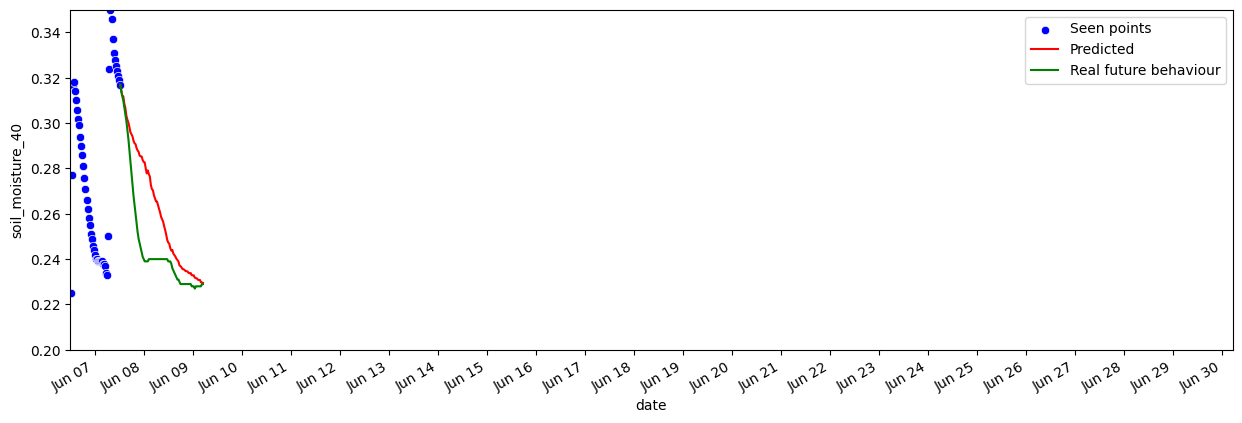

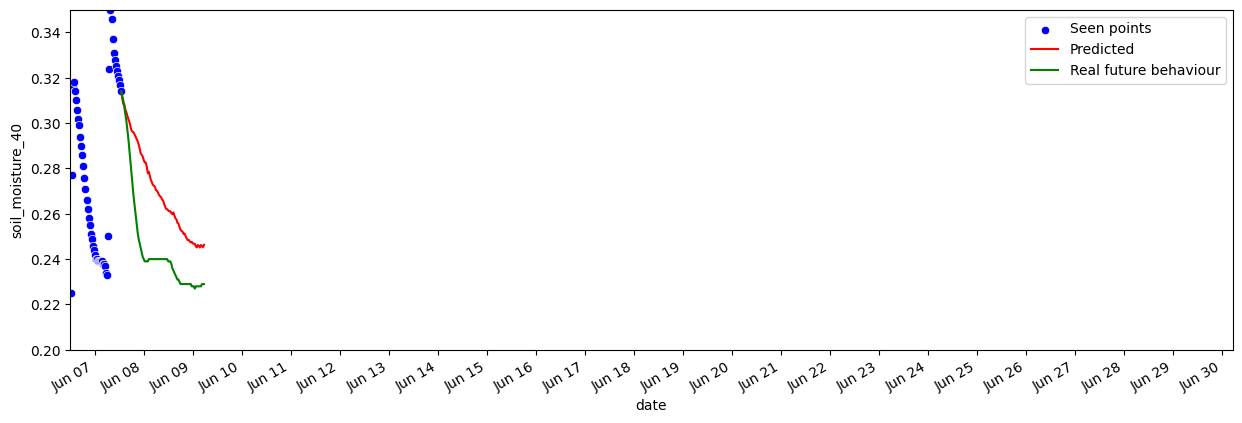

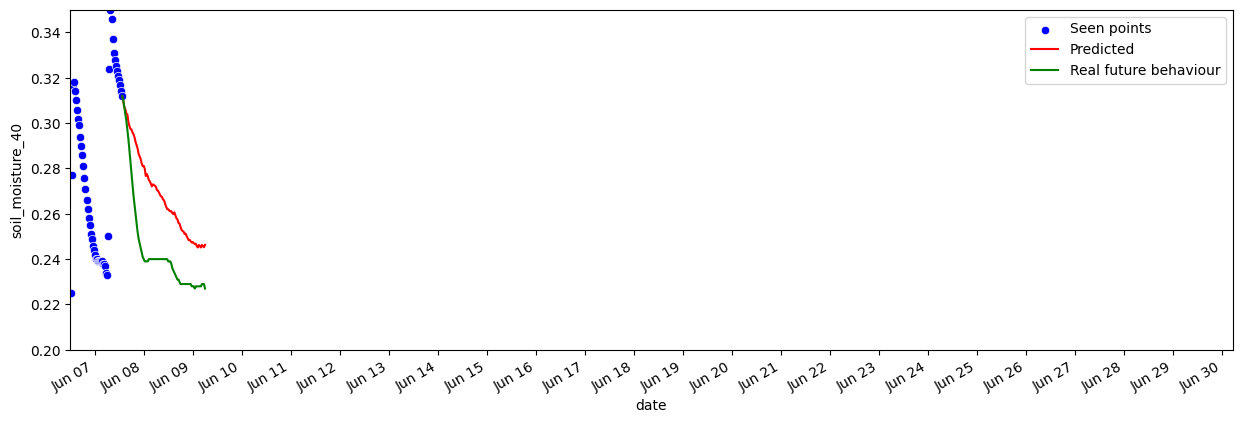

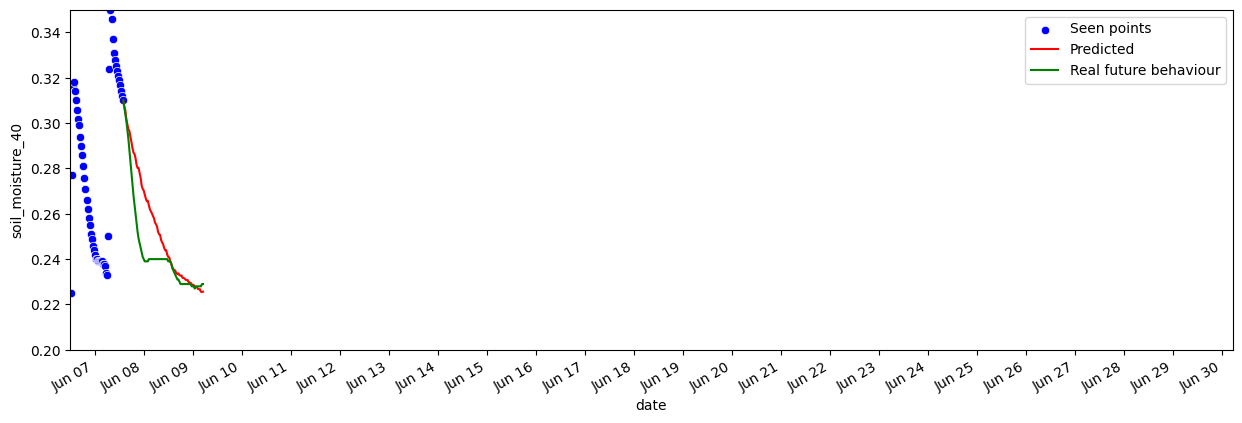

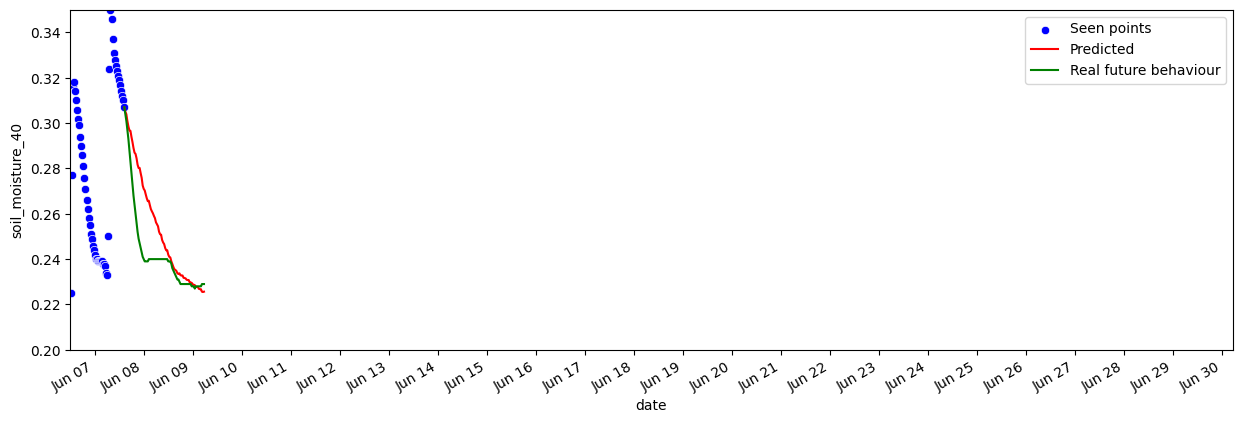

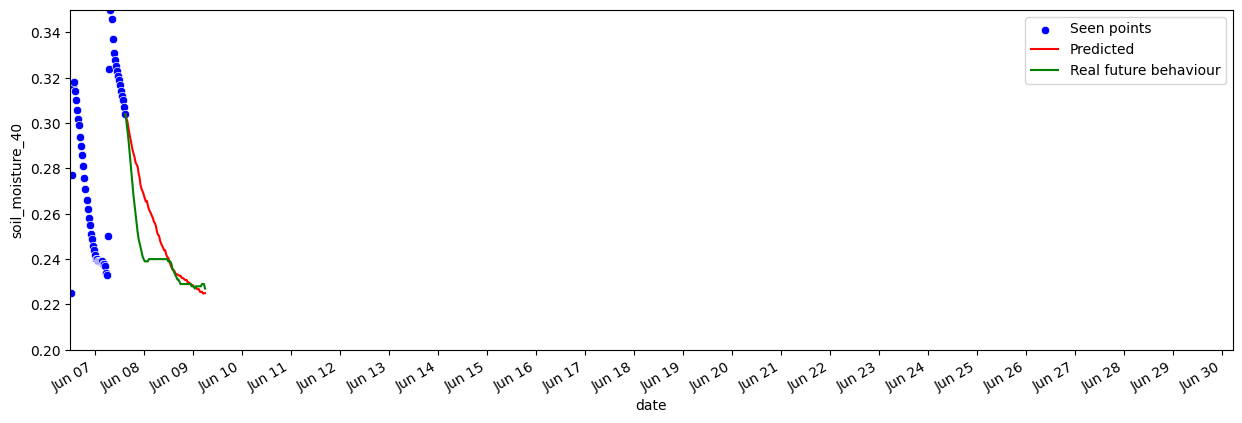

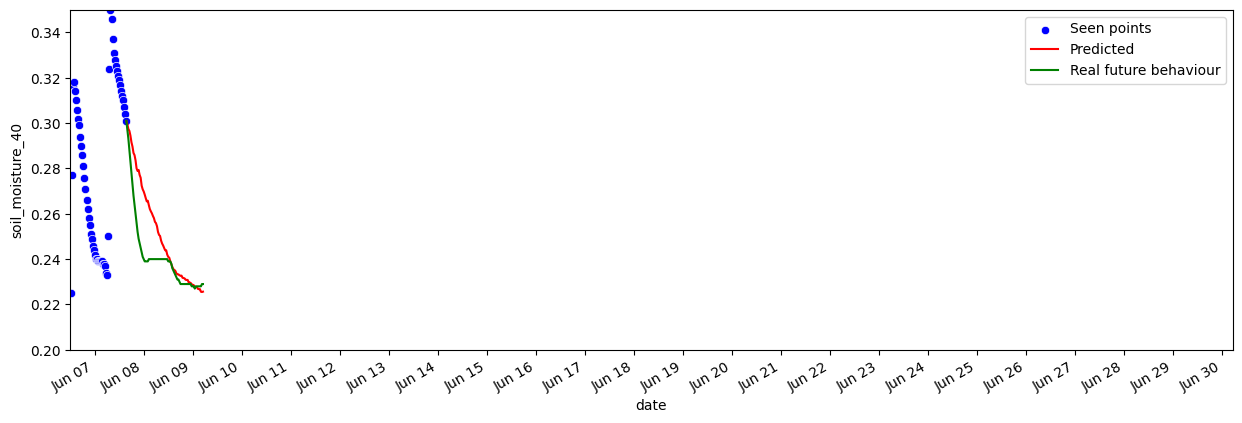

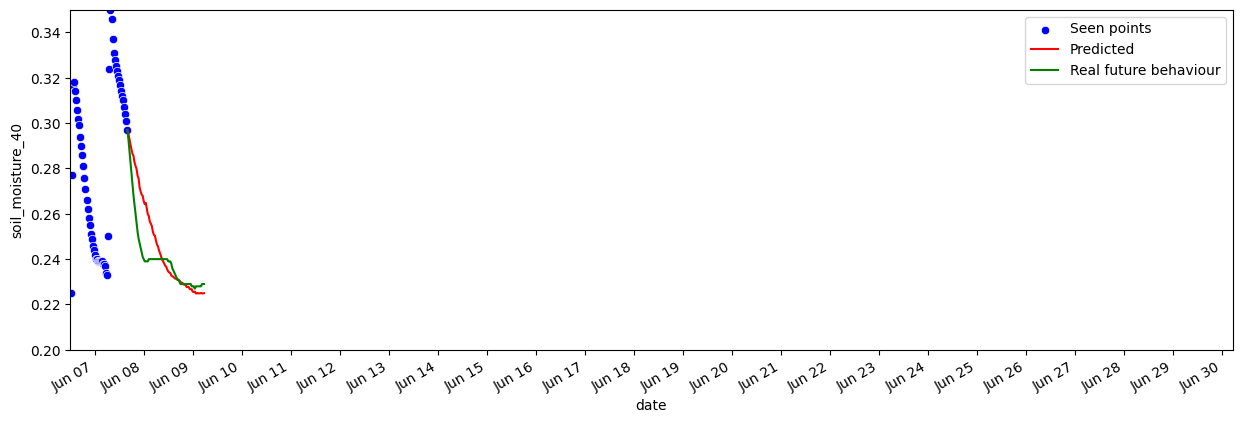

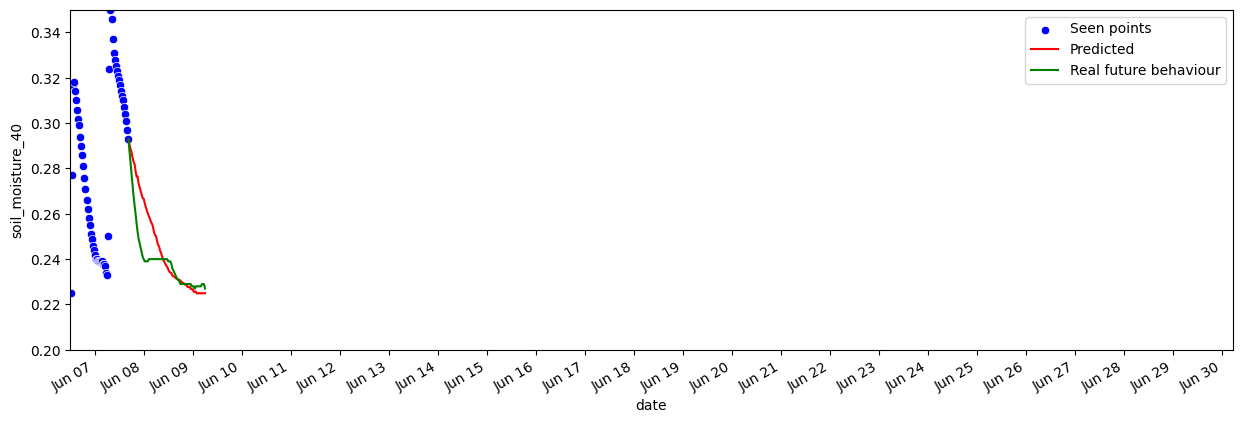

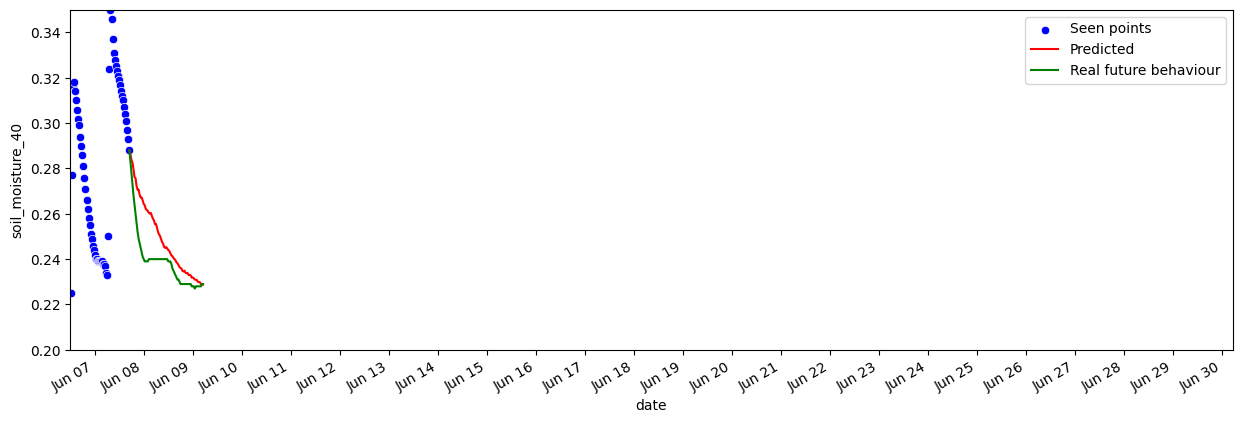

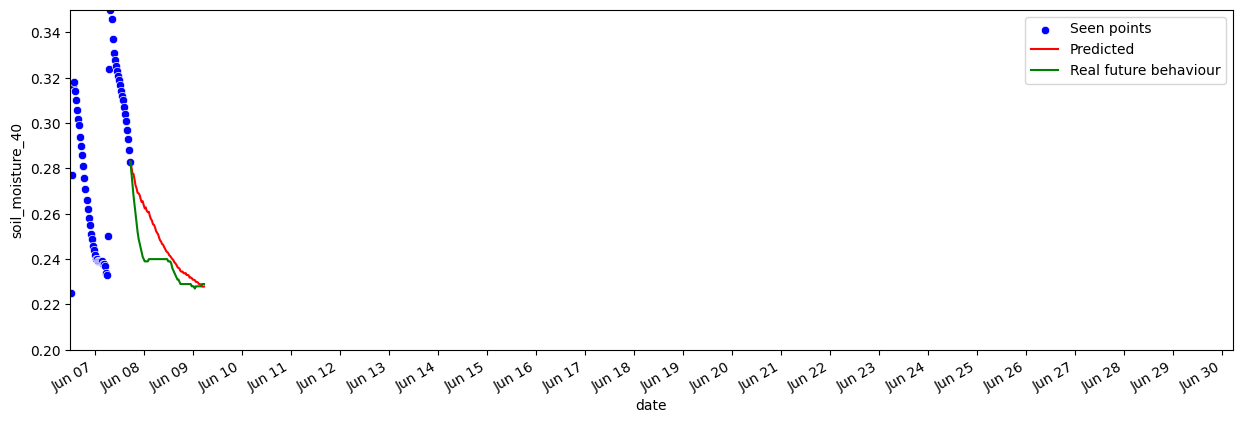

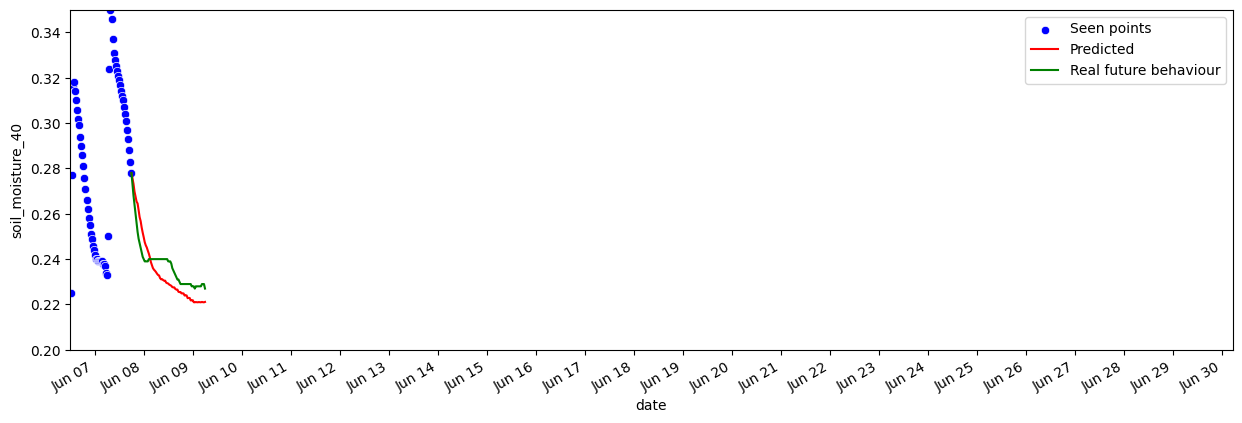

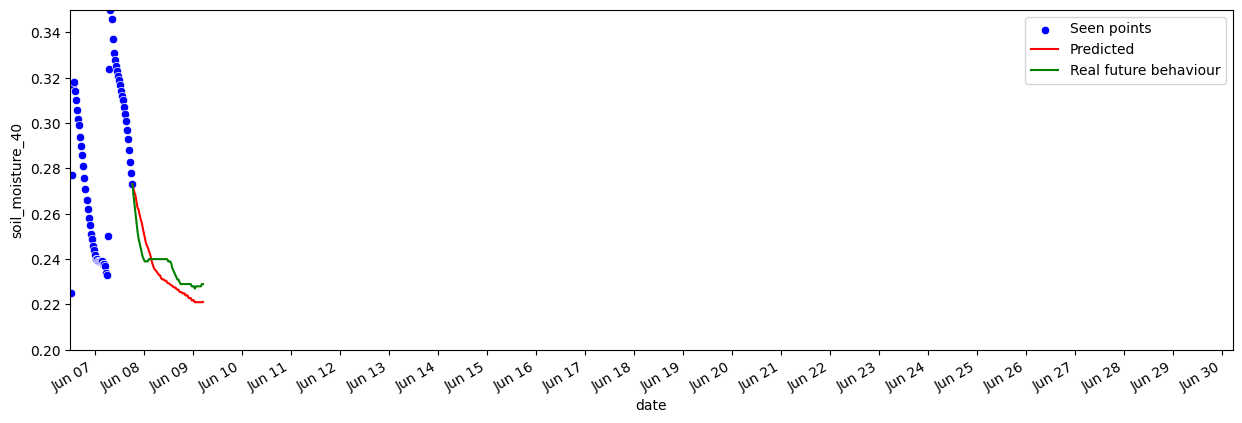

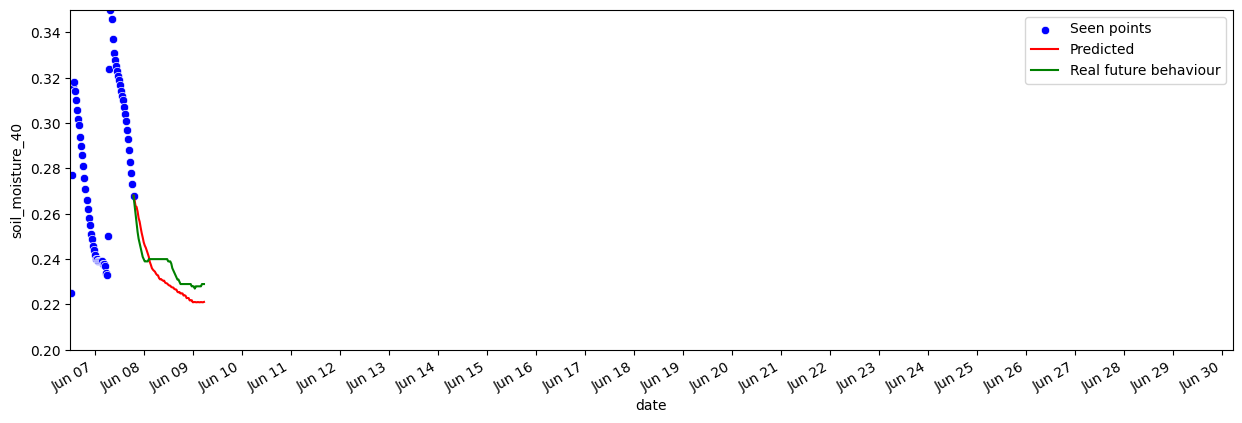

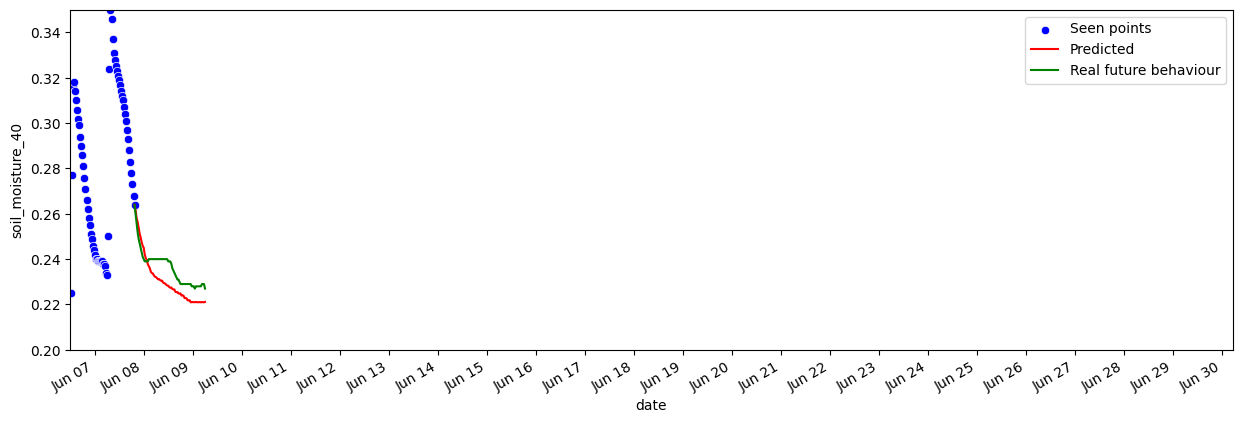

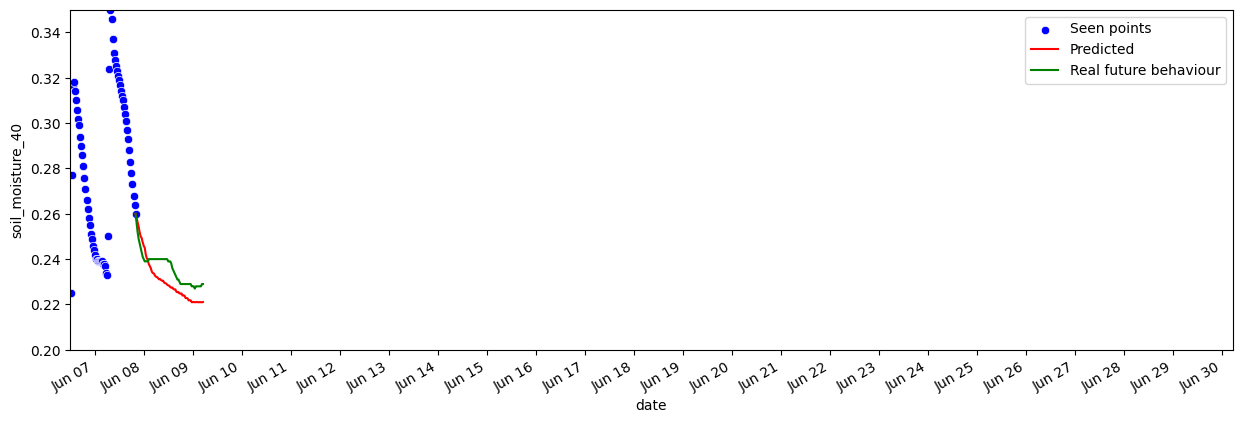

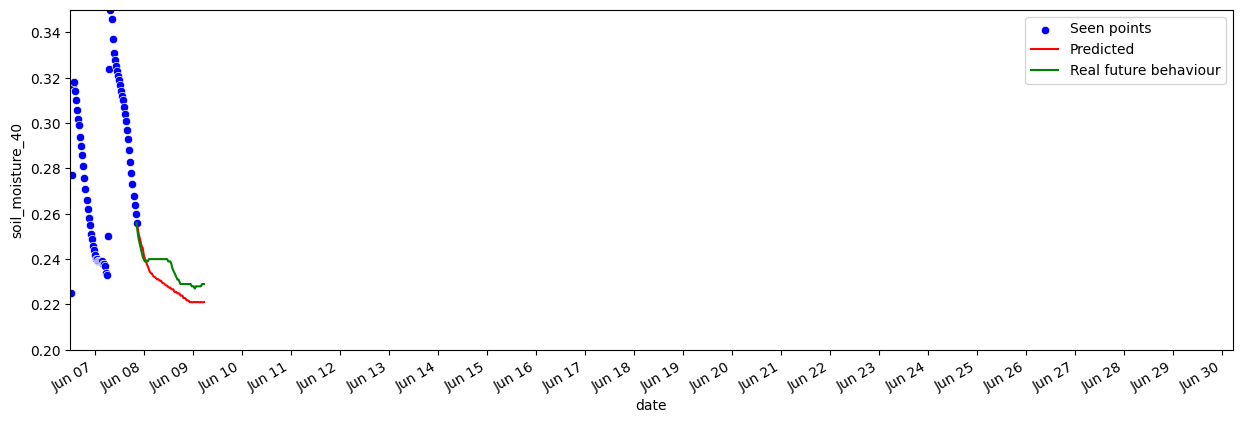

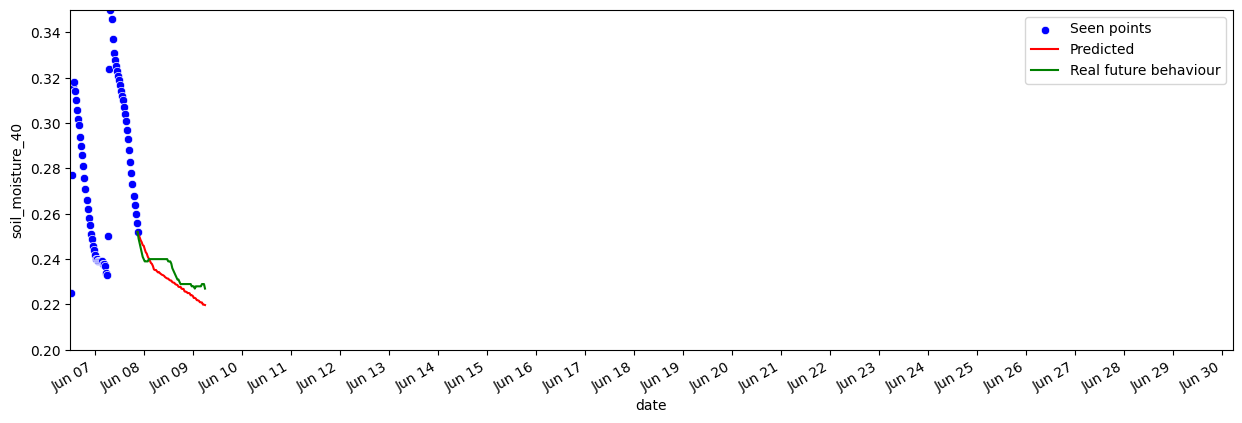

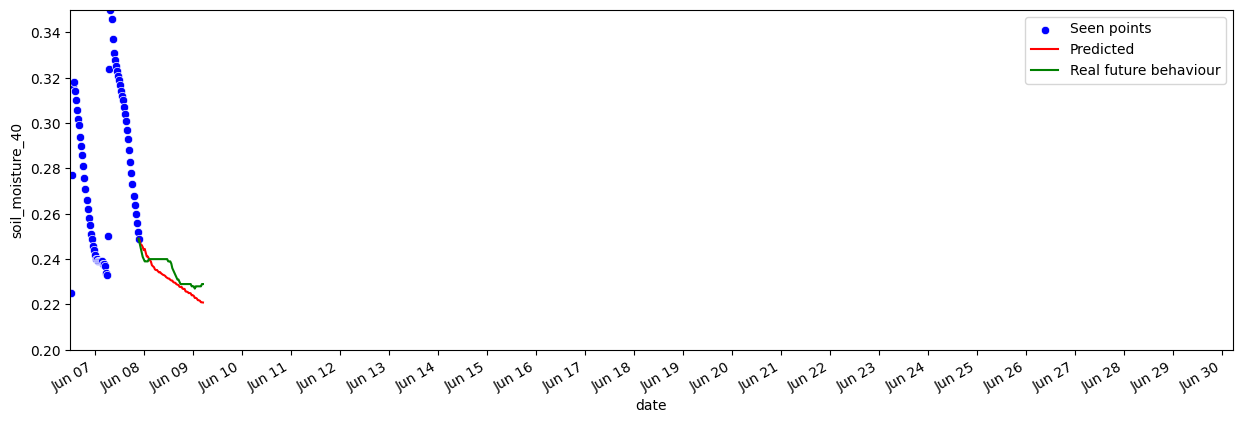

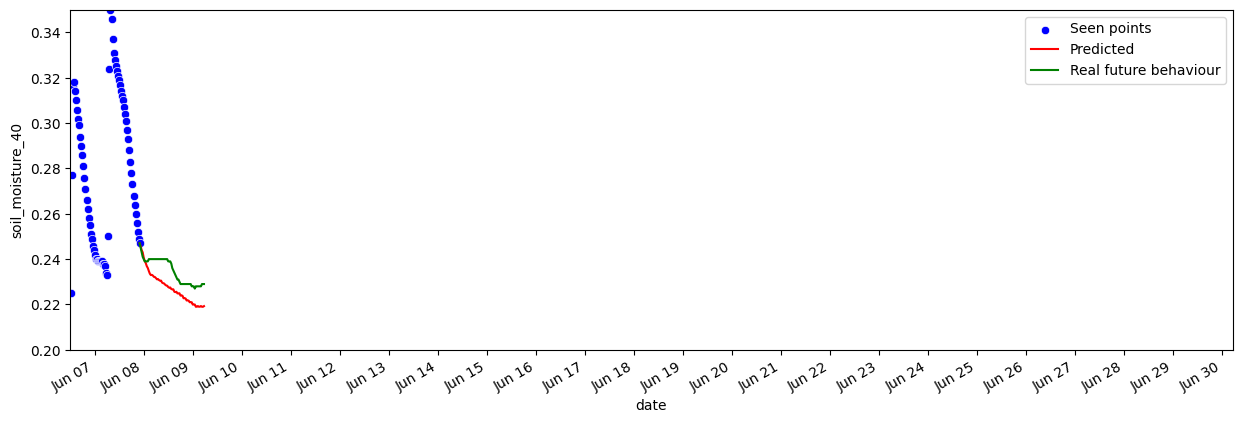

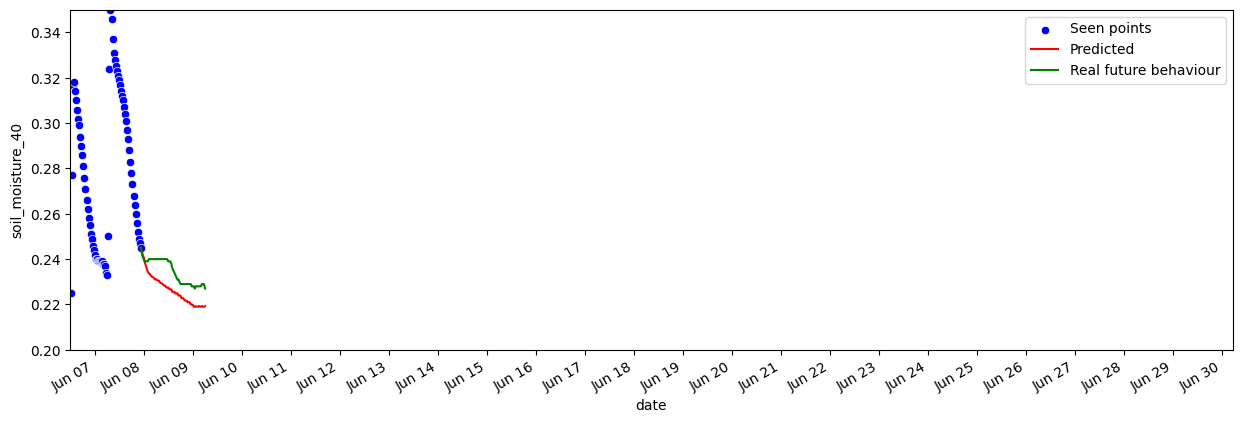

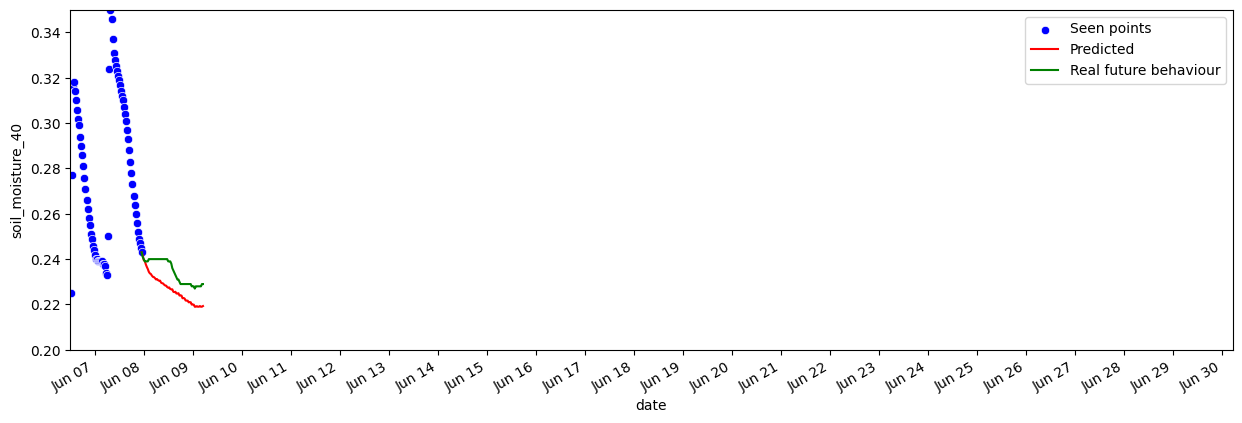

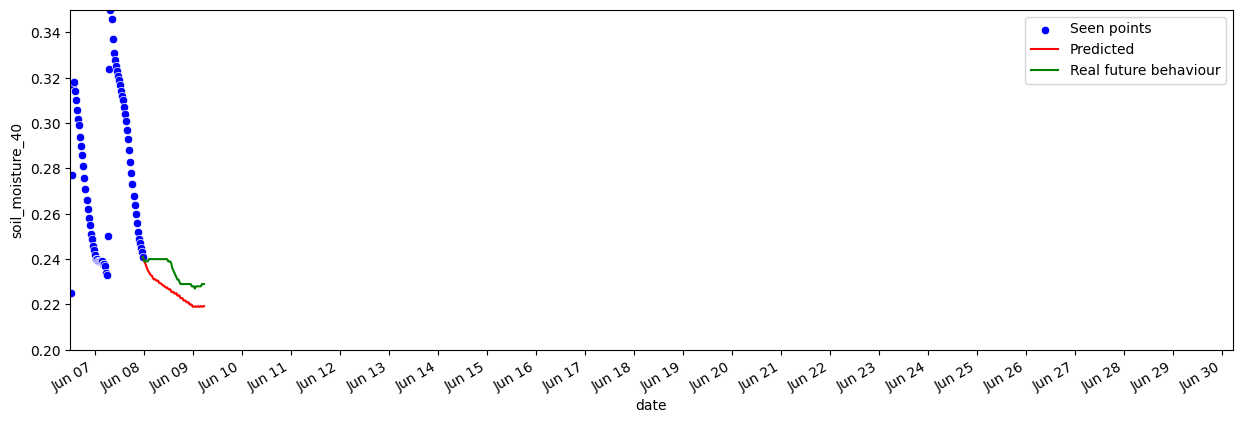

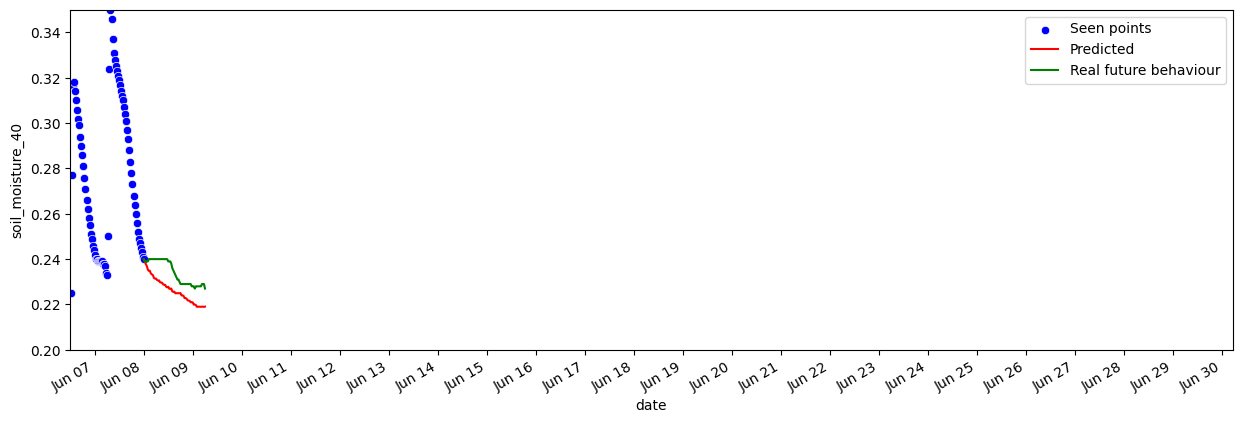

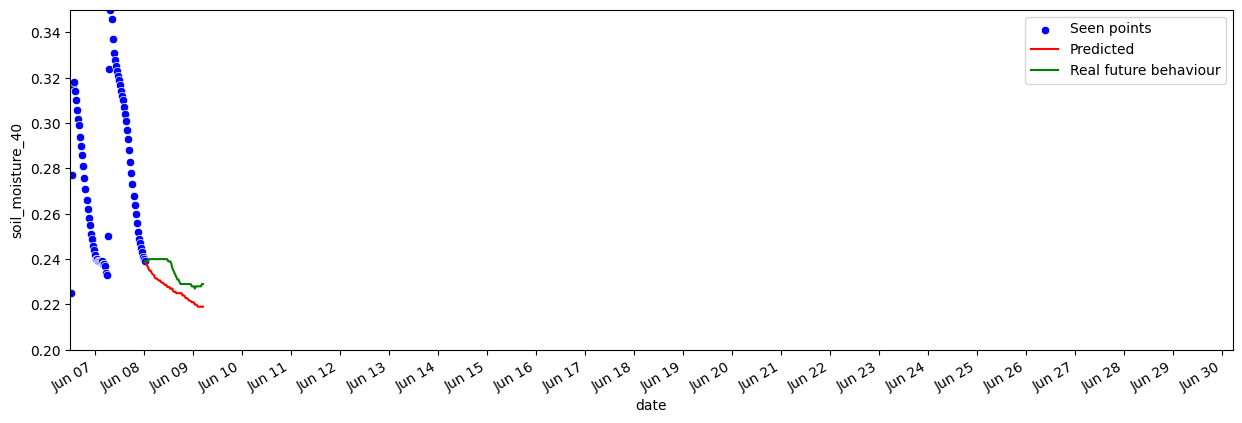

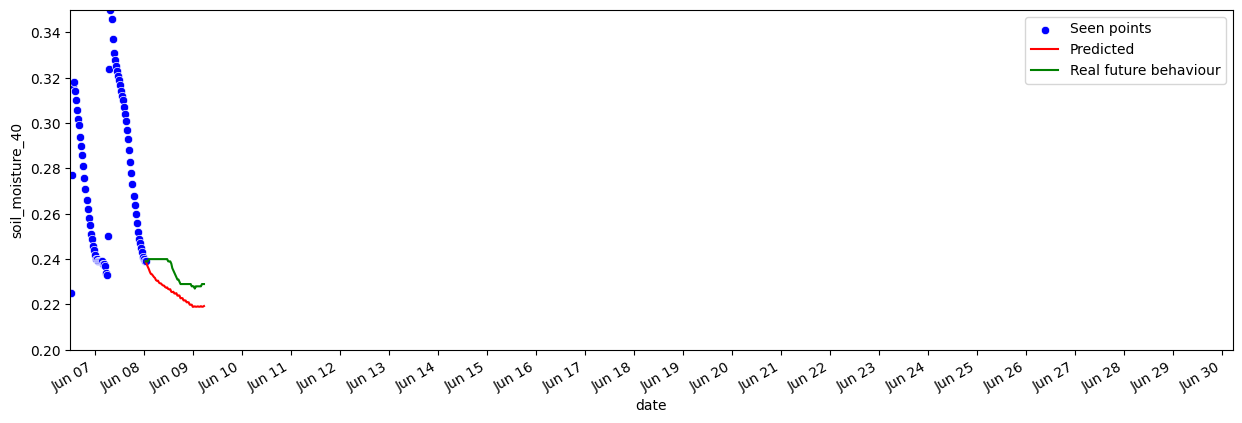

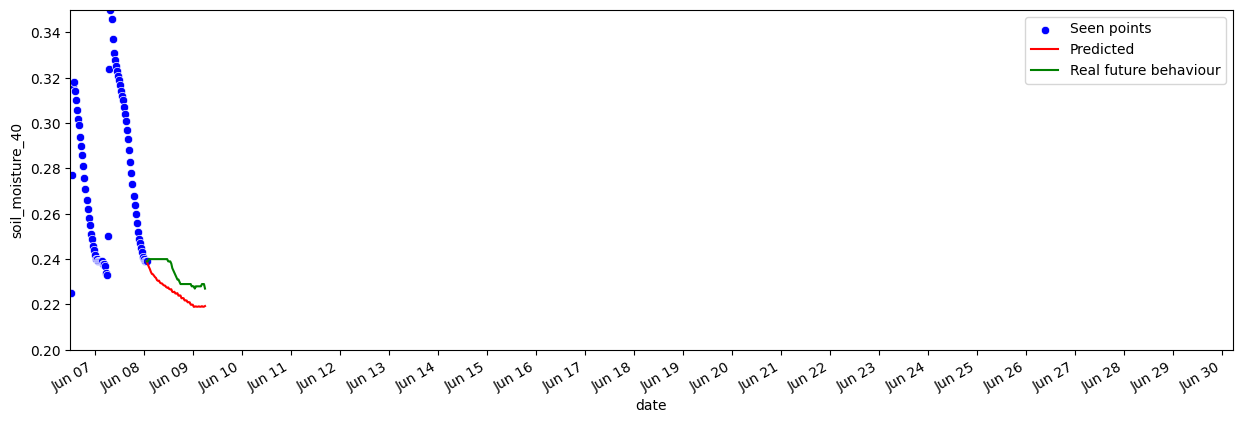

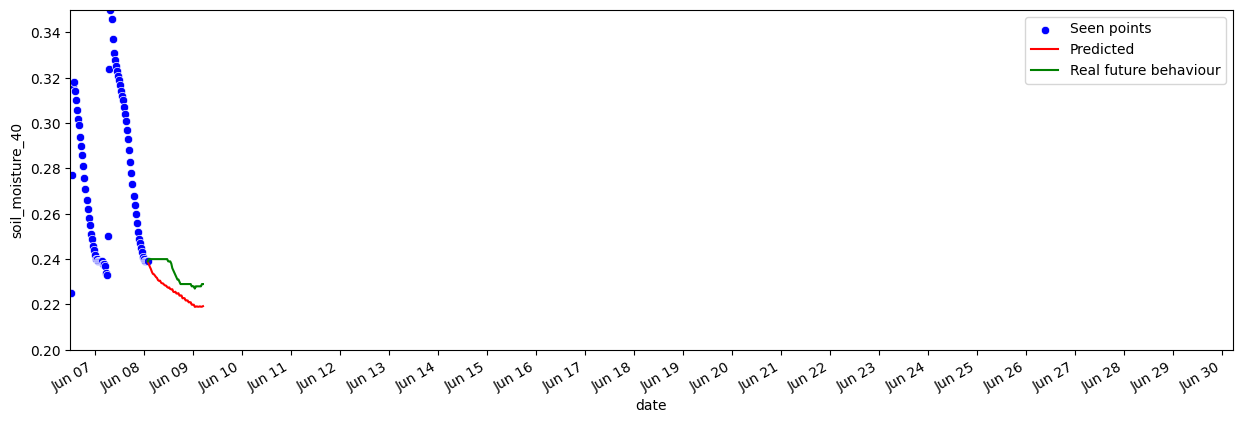

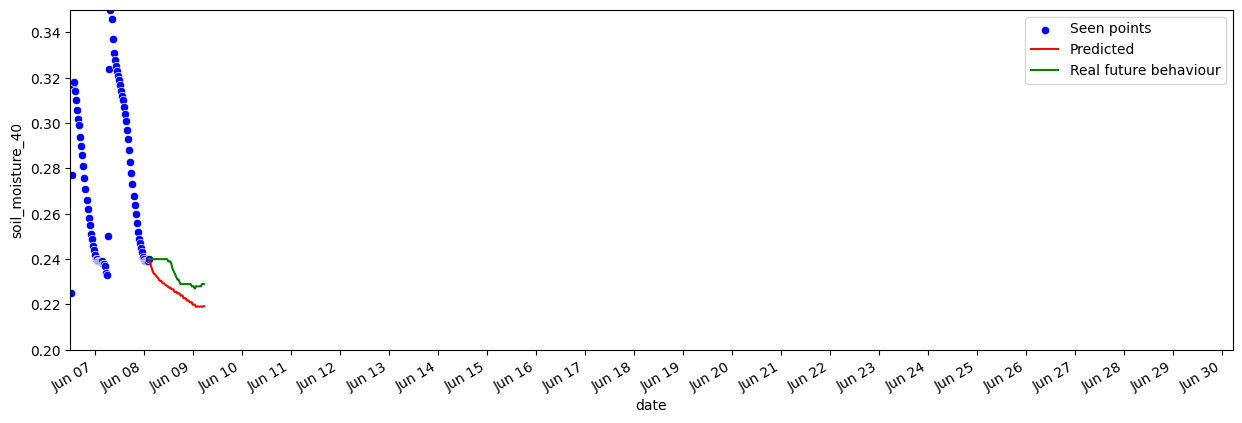

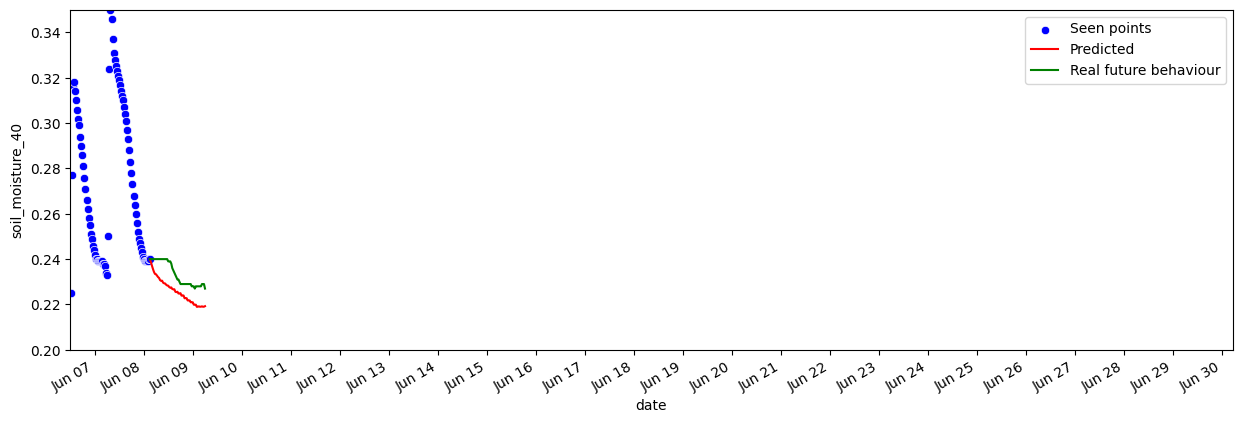

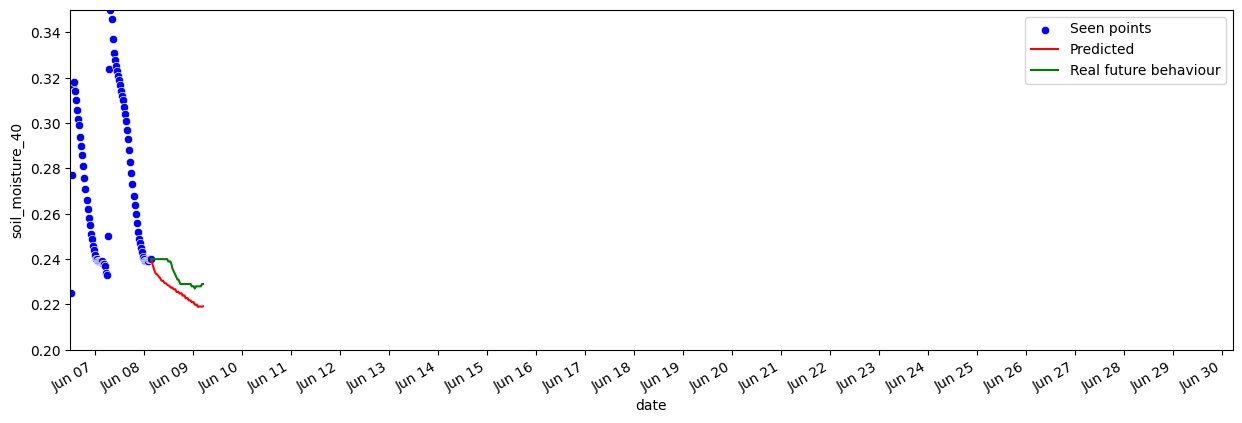

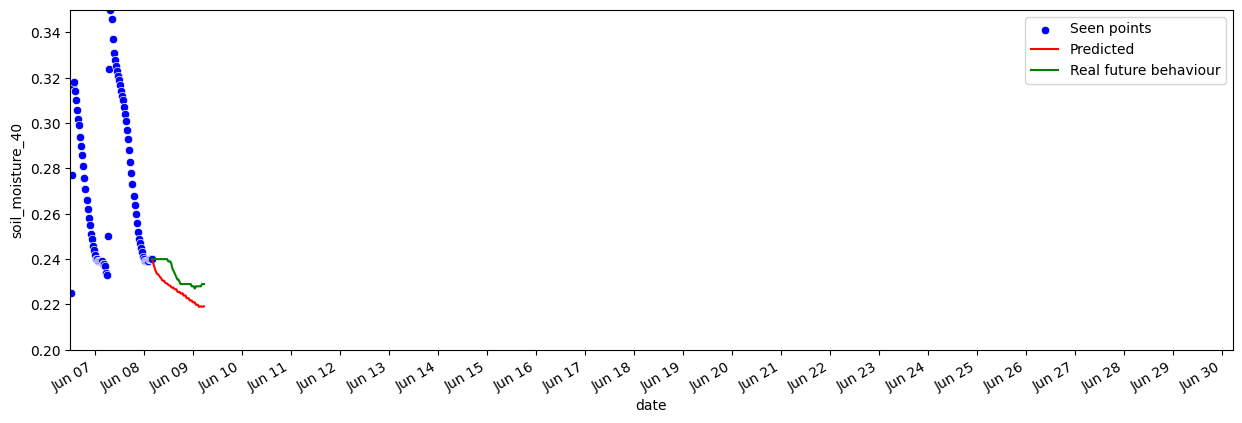

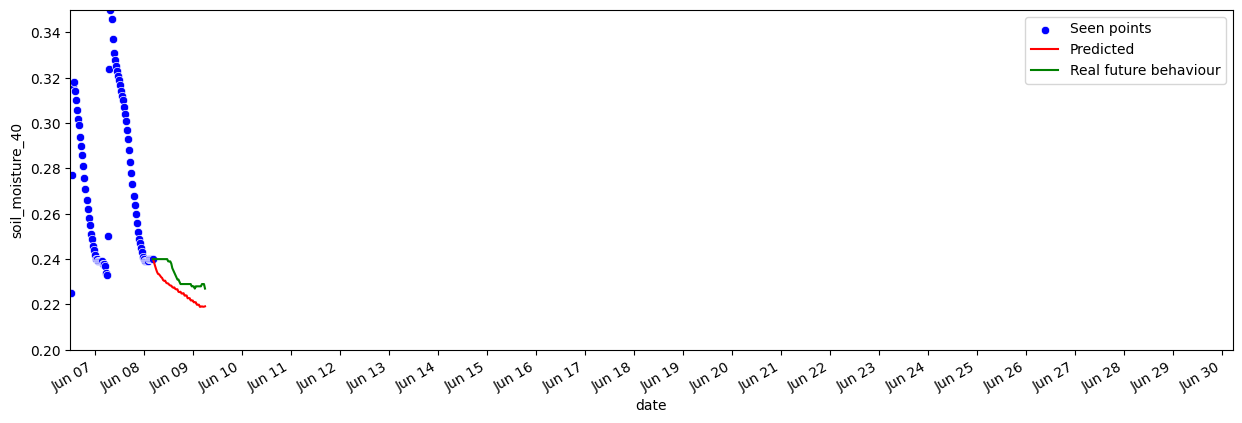

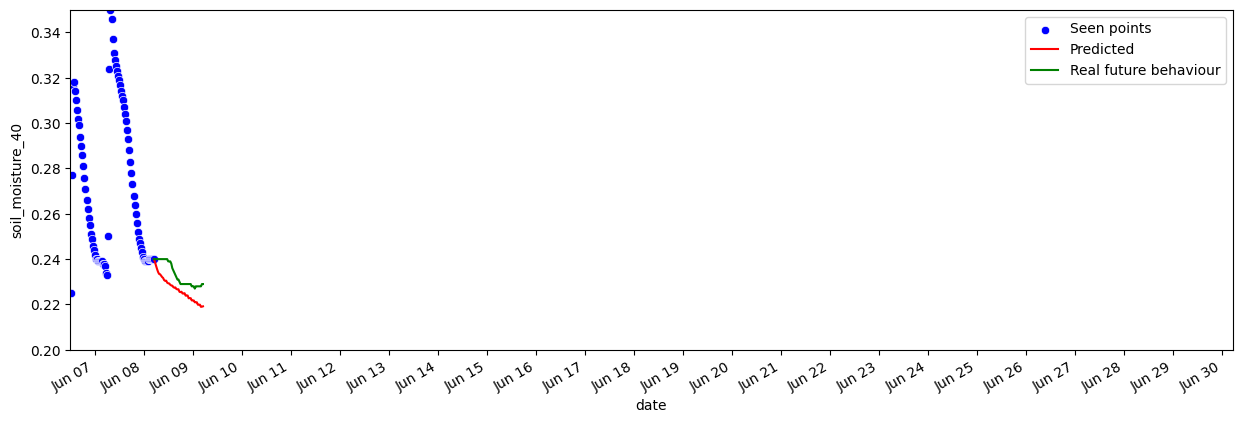

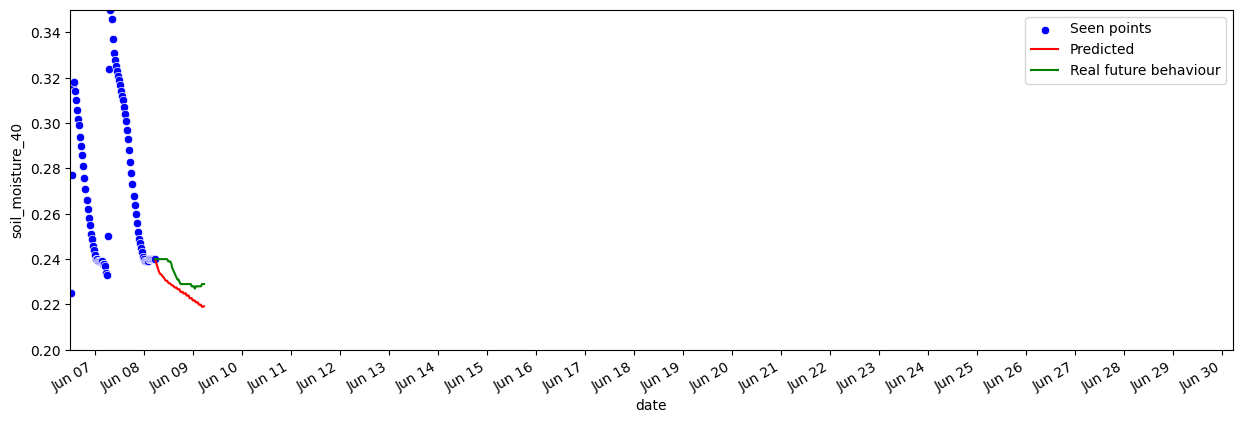

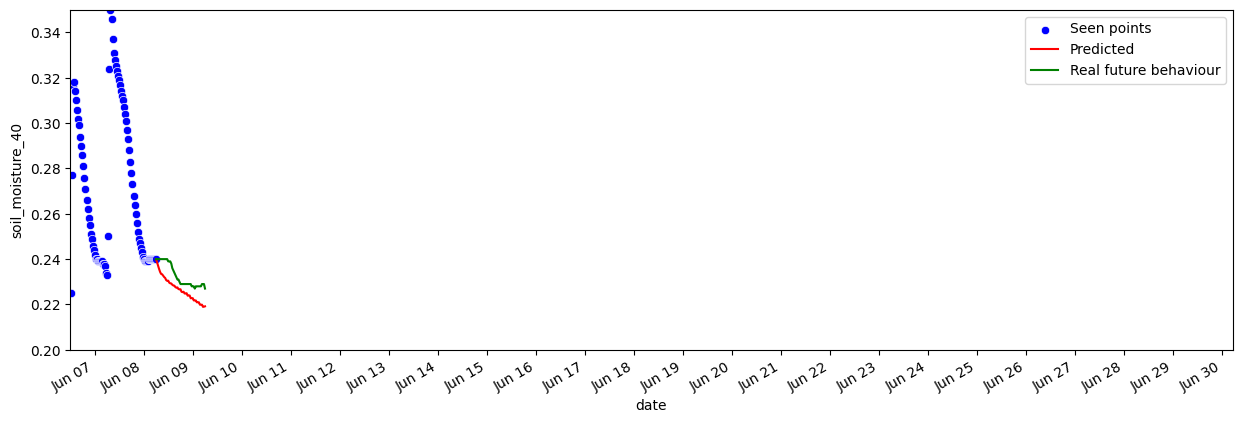

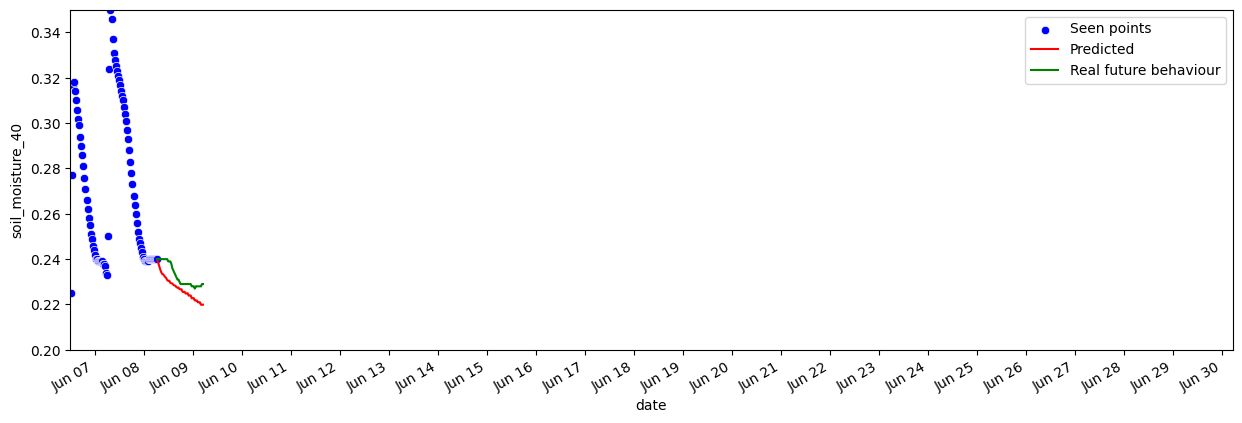

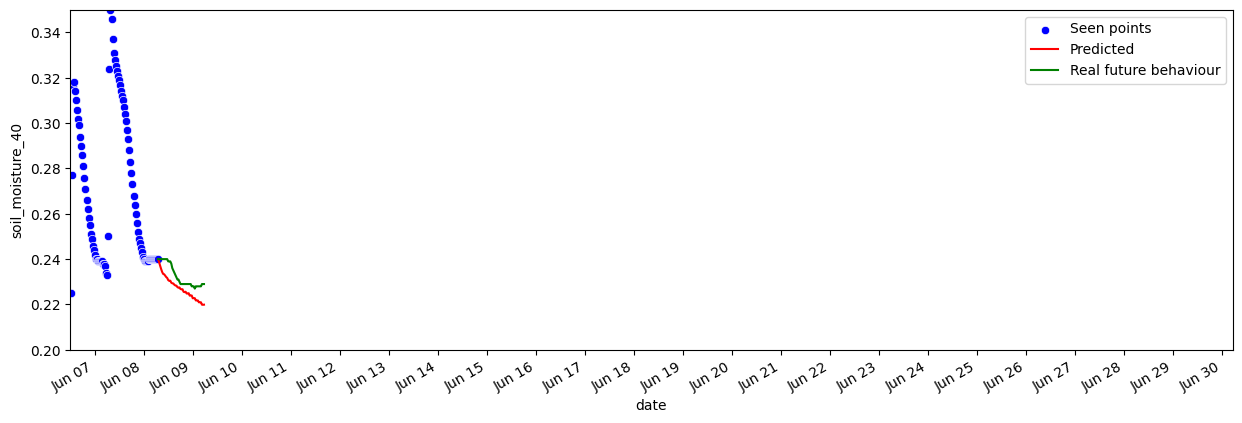

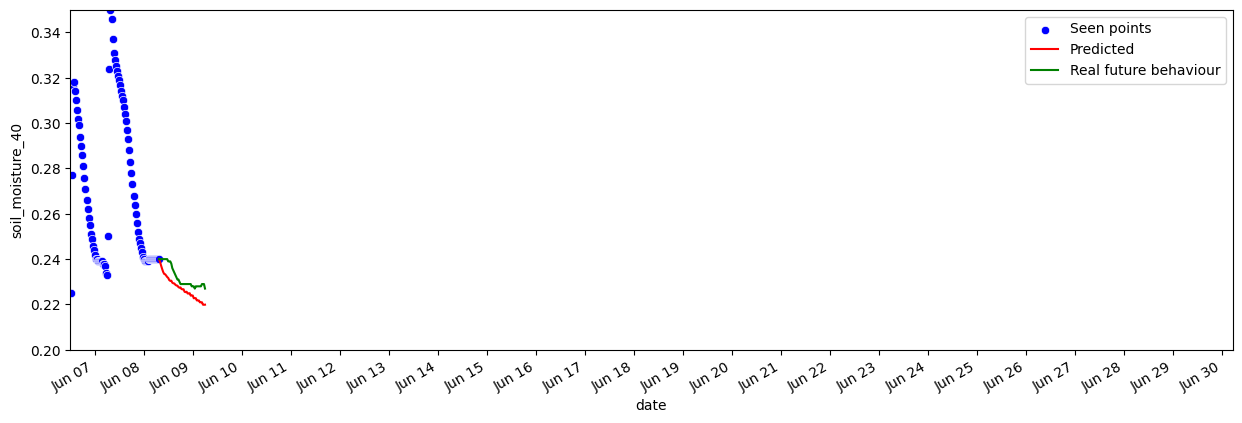

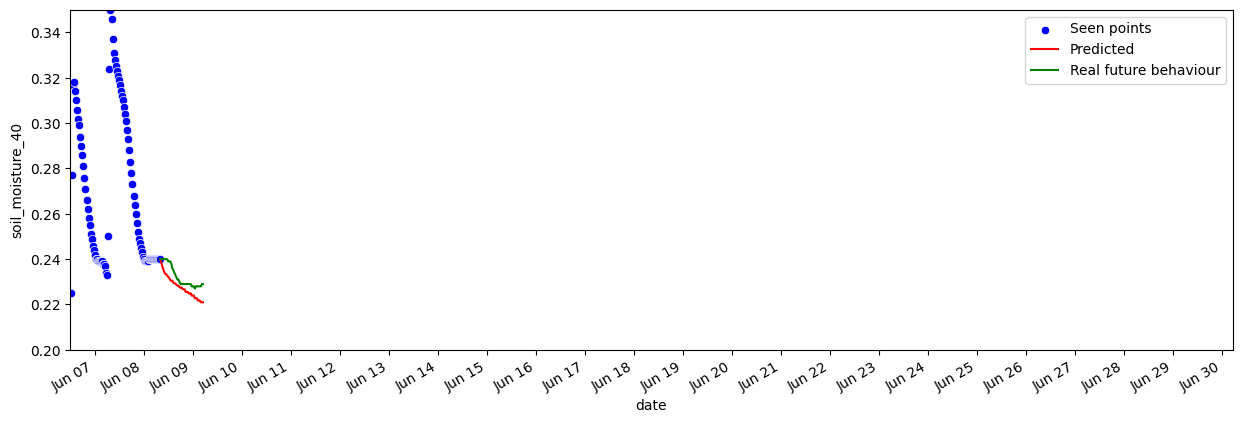

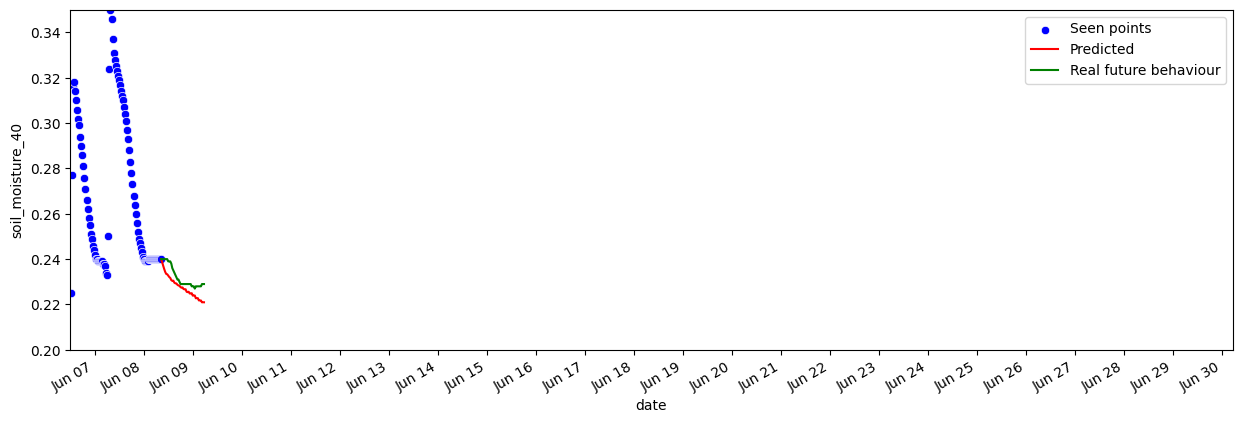

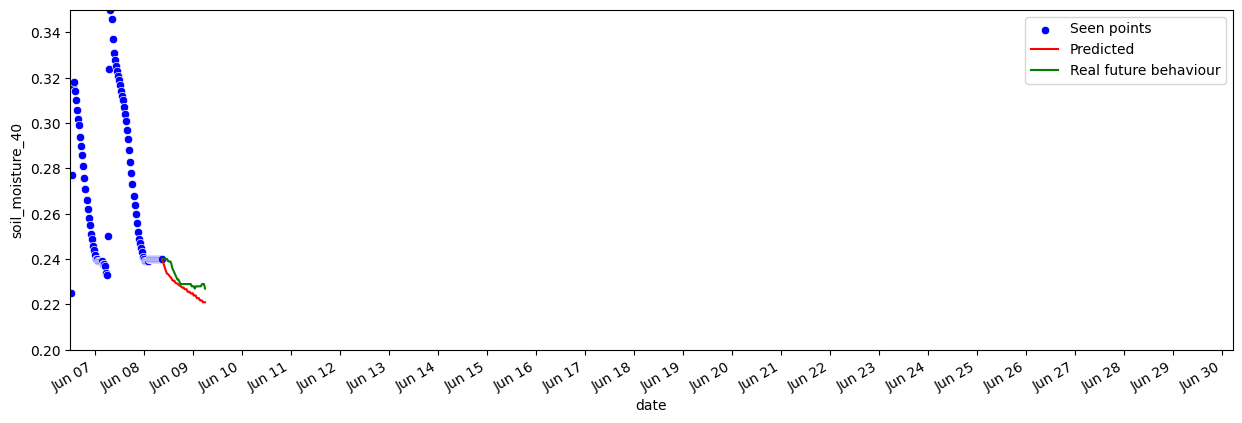

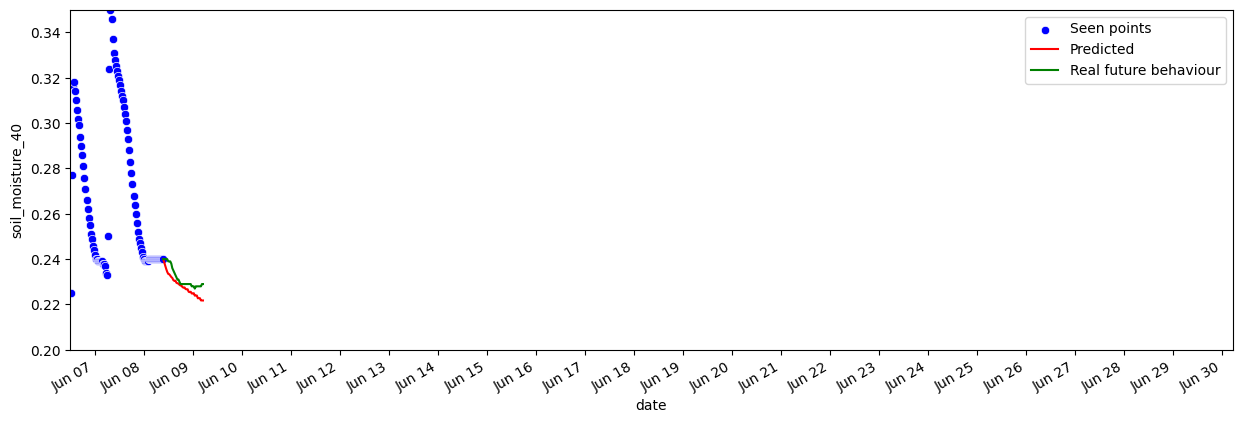

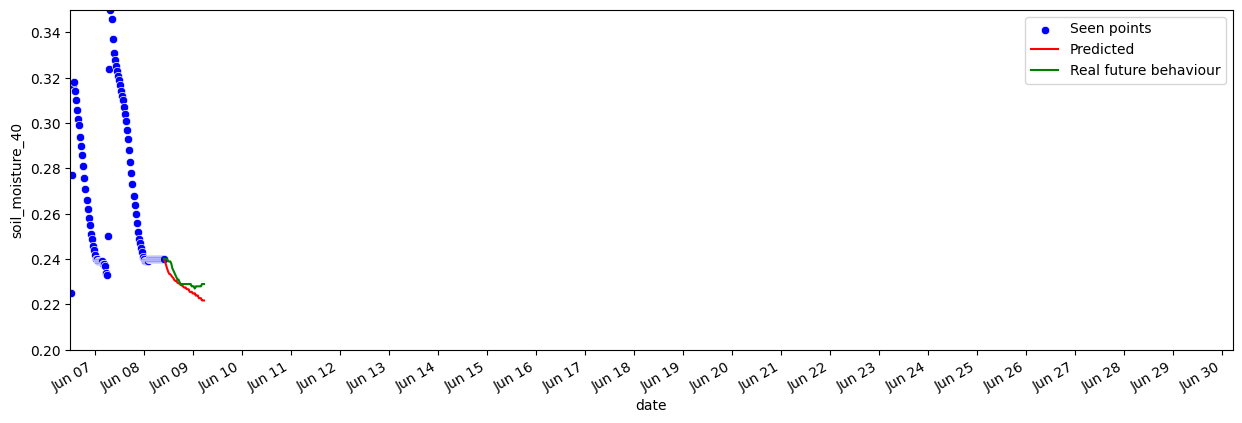

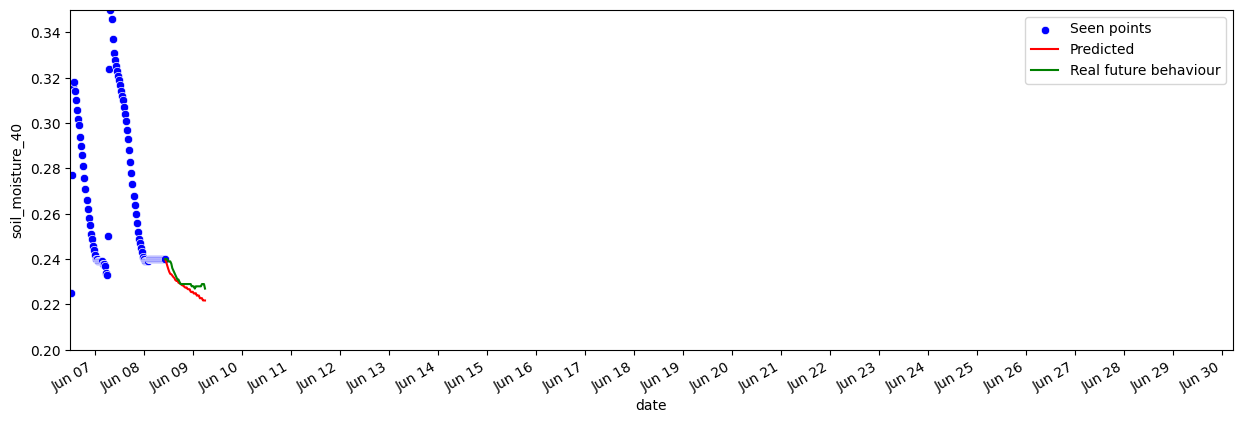

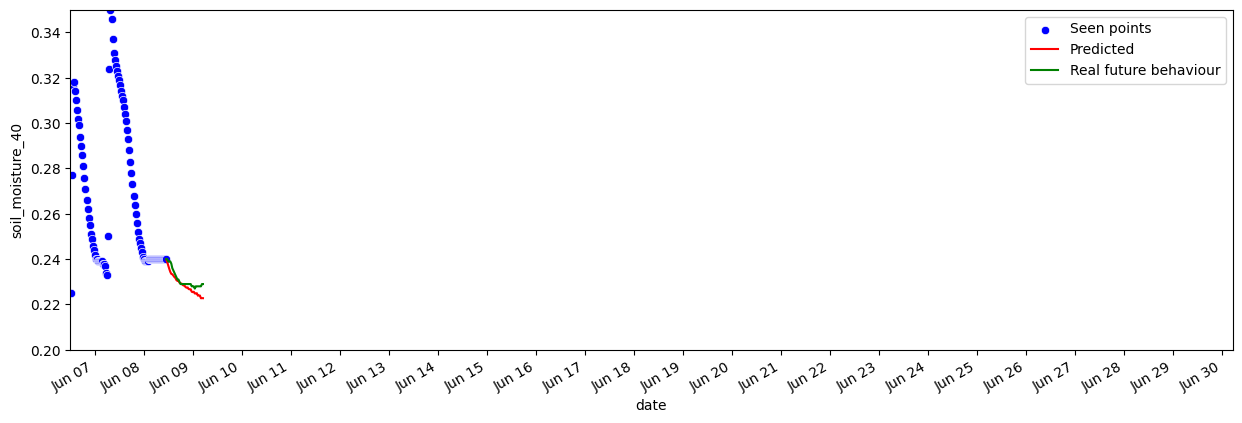

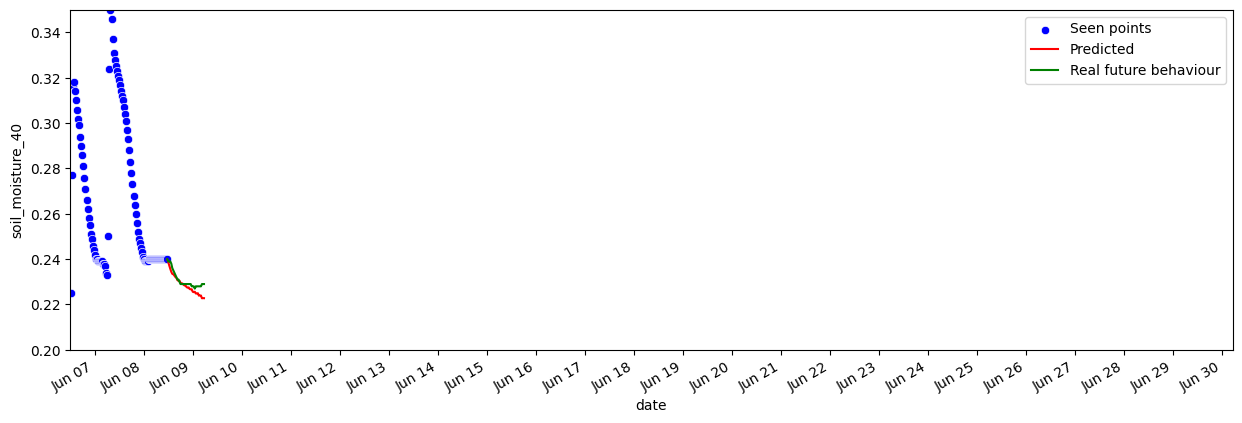

KeyboardInterrupt: 

In [ ]:
start_date = pd.to_datetime("2024-06-06 12:00:00")
end_date   = pd.to_datetime("2024-06-30 05:00:00")
df_constricted = df[(df["date"] >= start_date) & (df["date"] <= end_date)]

df_predicted = df.copy()

df_predicted["season"] = df_predicted["date"].dt.month.apply(get_season)

df_predicted = pd.get_dummies(df_predicted, columns=['season'])

df_predicted = df_predicted[(df_predicted["date"] >= start_date) & (df_predicted["date"] <= end_date)]
mask = df_predicted["irrigation_volume_0"] > 0
first_point = mask[mask].index[0]
df_predicted = df_predicted.loc[first_point:].copy()

epoch = 0

beginning_idx = df_predicted.index[0]
current_points = []
errors = pd.DataFrame()

#Simulates the passing of time and arrival of data to see the evolution of the forecastings
for idx in df_predicted.index:

    if df_predicted.loc[idx, "irrigation_volume_0"] > 0:
        current_points = []
        
        continue


    current_points.append(df_predicted.loc[idx, "soil_moisture_40"])

    new_prediction = update_prediction(df_predicted.copy(), xgb_reg, idx)

    predicted = new_prediction["soil_moisture_40"].values
    real_values = new_prediction["real_values"].values
    row = {}
    i = 0

    for i in range(len(predicted)):
        row[str(i)] = abs(predicted[i] - real_values[i])
        if df_predicted.loc[idx + i, "irrigation_volume_0"] > 0:
            row[str(i)] = np.nan

    errors = pd.concat([errors, pd.DataFrame([row])], ignore_index=True)
    
    create_frame_pointed(df_predicted, new_prediction, epoch, idx)

    epoch += 1

            


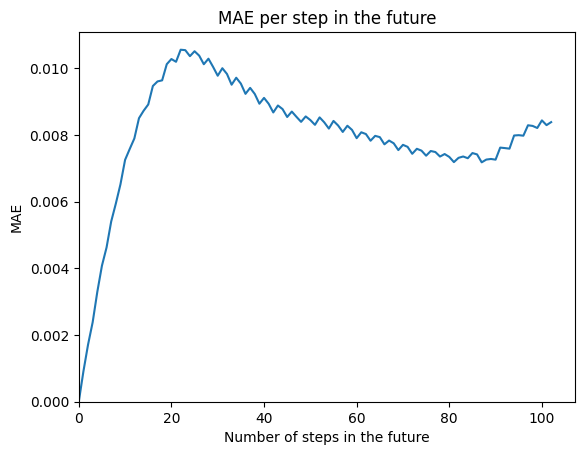

In [ ]:
mae_per_step = errors.mean().to_numpy()
plt.plot(mae_per_step)
plt.title("MAE per step in the future")
plt.ylabel("MAE")
plt.xlabel("Number of steps in the future")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

In [ ]:
# import imageio.v2 as imageio
# from pathlib import Path

# image_files = sorted(Path("frames_ML").glob("*.png"))

# frames = [imageio.imread(img) for img in image_files]

# imageio.mimsave("animation_ML.gif", frames, fps=1)